In [1]:
import torch
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:256'

In [2]:
torch.cuda.is_available(), torch.cuda.device_count()

(True, 1)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy
import os
import numpy as np
import pandas as pd
from upsetplot import UpSet, plot
import matplotlib.pyplot as plt
from collections import defaultdict 

dirname = 'mnist-infl-per-layer'

dirname_real = '/mnt/d/WhyNeuralNetsFinal'

In [5]:
import torchvision

train = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, 
                                  transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]))
test = torchvision.datasets.MNIST(root='./mnist', train=False,
                                        download=True, 
                                  transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]))

In [6]:
epochs = 20

# make resnet 18 model
model_ft = models.resnet18()

# change input layer
# the default number of input channel in the resnet is 3, but our images are 1 channel. So we have to change 3 to 1.
# nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) <- default
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

# change fc layer
# the number of classes in our dataset is 10. default is 1000.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss()

model_ft = model_ft.to(device)

# Let's aggregate influences

In [7]:
# Create a DataLoader with a batch size equal to the dataset size (i.e., load all data at once)
batch_size = len(train)
train_loader = torch.utils.data.DataLoader(train, batch_size=128 * 8, shuffle=False, num_workers=8)
test_loader = torch.utils.data.DataLoader(test, batch_size=128 * 8, shuffle=False, num_workers=8)

# Load the data as a single batch and extract the images tensor
# for images, labels in train_loader:
#     train_tensor = images
#     labels_tensor = labels

In [8]:
def get_probs(model, only_correct=True, loader=train_loader):
    prob_list = []
    
    model.to(device)
    model.eval()
    
    X = train_tensor.to(device)
    Y = labels_tensor.to(device)
    with torch.no_grad():
        for images, labels in tqdm(loader, leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            if only_correct:
                prob_list.append(probs[torch.arange(probs.size(0)), labels].cpu())
            else:
                prob_list.append(probs.cpu())
    return torch.cat(prob_list, dim=0)

In [9]:
# Add evaluation of the test data
for layer in tqdm(range(len(list(model_ft.children()))), desc='Layer', position=0):
    children = list(model_ft.children())
    nn_layer = children[layer]
    if len(list(nn_layer.parameters())) == 0:
        print(f'skipping {layer} bc no params')
        continue
        
    for i in tqdm(range(0, 160), position=1, leave=False):
        path = Path(dirname) / f'layer_{layer}' / f'{i}'
        if not os.path.exists(path):
            print(f'{path} does not exist')
            continue
        try:
            d = torch.load(path)
        except Exception as e:
            print(f'error loading {path}: {e}')
            continue
        
            
        model_state = d['model_state']
        probs = d['probs']
        subset_idx = d['indexes']
        test_probs = d['test_probs']
                    
        model_ft.load_state_dict(model_state)
        
        if test_probs.shape[0] == 10 * 1000:
            continue
            
        test_probs = get_probs(model_ft, loader=test_loader)
        #print(test_probs.shape)
        probs = get_probs(model_ft)
        #print(f'{str(path)}, train={probs.mean().item():.3f}, test={test_probs.mean().item():.3f}')

        torch.save({
            'model_state': model_state,
            'probs': probs,
            'indexes': subset_idx,
            'test_probs': test_probs
        }, path)

In [9]:
def get_agg_location(layer, lower, upper):
    return Path(dirname_real) / f'layer_{layer}' / f'agg_{lower}_{upper - 1}'

In [10]:
def get_test_agg_location(layer, lower, upper):
    return Path(dirname_real) / f'layer_{layer}' / f'test_agg_{lower}_{upper - 1}'

In [12]:
batch_size = 60*1000
for lower in tqdm(range(0, 60000, batch_size), position=0):
    lower, upper = lower, lower + batch_size
    for layer in tqdm(range(len(list(model_ft.children()))), desc='Layer', position=1, leave=False):
        test_estimates_with = torch.zeros((batch_size, 10 * 1000))
        test_estimates_without = torch.zeros((batch_size, 10 * 1000))
        num_with = torch.zeros(batch_size)

        num_total = 0
        children = list(model_ft.children())
        nn_layer = children[layer]
        if len(list(nn_layer.parameters())) == 0:
            print(f'skipping {layer} bc no params')
            continue

        for i in tqdm(range(160), position=2, leave=False):
            path = Path(dirname) / f'layer_{layer}' / f'{i}'
            if not os.path.exists(path):
                print(f'{path} does not exist')
                continue

            try:
                d = torch.load(path)
            except Exception as e:
                print(f'error loading {path}: {e}')
                continue

            num_total += 1            
            test_probs = d['test_probs']

            subset_idx = d['indexes']
            subset_idx = subset_idx.sort().values.unique()
            subset_idx = subset_idx[(subset_idx < batch_size) & (subset_idx >= 0)]

            subset_mask = torch.zeros(batch_size, dtype=torch.int64)
            subset_mask[subset_idx] = 1

            num_with[subset_mask.bool()] += 1

            test_estimates_with[subset_idx] += test_probs
            test_estimates_without[subset_mask.bool() == False] += test_probs
            
        path =  get_test_agg_location(layer, lower, upper)
        print(f'Saving {path}')
        torch.save({
            'test_estimates_with': test_estimates_with,
            'test_estimates_without': test_estimates_without,
            'num_with': num_with,
            'num_total': num_total
        }, path)

  0%|          | 0/1 [00:00<?, ?it/s]

Layer:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
# Let's create estimates with and without
batch_size = 10*1000
for lower in tqdm(range(0, 60000, batch_size), position=0):
    lower, upper = lower, lower + batch_size

    for layer in tqdm(range(len(list(model_ft.children()))), desc='Layer', position=1, leave=False):
        estimates_with = torch.zeros((batch_size, 60000))
        estimates_without = torch.zeros((batch_size, 60000))
        num_with = torch.zeros(batch_size)

        num_total = 0
        children = list(model_ft.children())
        nn_layer = children[layer]
        if len(list(nn_layer.parameters())) == 0:
            print(f'skipping {layer} bc no params')
            continue
            
        path =  get_agg_location(layer, lower, upper)
        if os.path.exists(path):
            try:
                res = torch.load(path)
                if 'num_total' in res:
                    print(f'Found num_total in {path}. Skipping')
                    continue
                else:
                    print(f'num_total not in {path}. Creating')
            except:
                print(f'error reading {path}. Not skipping')

        for i in tqdm(range(160), position=2, leave=False):
            path = Path(dirname) / f'layer_{layer}' / f'{i}'
            if not os.path.exists(path):
                print(f'{path} does not exist')
                continue
            
            try:
                d = torch.load(path)
            except Exception as e:
                print(f'error loading {path}: {e}')
                continue
                
            num_total += 1
            if 'probs' not in d:
                continue
            probs = d['probs']

            subset_idx = d['indexes']
            subset_idx = subset_idx.sort().values.unique()
            subset_idx = subset_idx - lower
            subset_idx = subset_idx[(subset_idx < batch_size) & (subset_idx >= 0)]

            subset_mask = torch.zeros(batch_size, dtype=torch.int64)
            subset_mask[subset_idx] = 1

            num_with[subset_mask.bool()] += 1

            estimates_with[subset_idx] += probs
            estimates_without[subset_mask.bool() == False] += probs

        path =  get_agg_location(layer, lower, upper)
        print(f'Saving {path}')
        torch.save({
            'estimates_with': estimates_with,
            'estimates_without': estimates_without,
            'num_with': num_with,
            'num_total': num_total
        }, path)

  0%|          | 0/6 [00:00<?, ?it/s]

Layer:   0%|          | 0/10 [00:00<?, ?it/s]

Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_0/agg_0_9999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_1/agg_0_9999. Skipping
skipping 2 bc no params
skipping 3 bc no params
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_4/agg_0_9999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_5/agg_0_9999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_6/agg_0_9999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_7/agg_0_9999. Skipping
skipping 8 bc no params
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_9/agg_0_9999. Skipping


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

num_total not in /mnt/d/WhyNeuralNetsFinal/layer_0/agg_10000_19999. Creating


  0%|          | 0/160 [00:00<?, ?it/s]

Saving /mnt/d/WhyNeuralNetsFinal/layer_0/agg_10000_19999
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_1/agg_10000_19999. Skipping
skipping 2 bc no params
skipping 3 bc no params
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_4/agg_10000_19999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_5/agg_10000_19999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_6/agg_10000_19999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_7/agg_10000_19999. Skipping
skipping 8 bc no params
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_9/agg_10000_19999. Skipping


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_0/agg_20000_29999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_1/agg_20000_29999. Skipping
skipping 2 bc no params
skipping 3 bc no params
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_4/agg_20000_29999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_5/agg_20000_29999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_6/agg_20000_29999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_7/agg_20000_29999. Skipping
skipping 8 bc no params
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_9/agg_20000_29999. Skipping


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

error reading /mnt/d/WhyNeuralNetsFinal/layer_0/agg_30000_39999. Not skipping


  0%|          | 0/160 [00:00<?, ?it/s]

Saving /mnt/d/WhyNeuralNetsFinal/layer_0/agg_30000_39999
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_1/agg_30000_39999. Skipping
skipping 2 bc no params
skipping 3 bc no params
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_4/agg_30000_39999. Skipping
Found num_total in /mnt/d/WhyNeuralNetsFinal/layer_5/agg_30000_39999. Skipping
error reading /mnt/d/WhyNeuralNetsFinal/layer_6/agg_30000_39999. Not skipping


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_6/140 does not exist
mnist-infl-per-layer/layer_6/141 does not exist
mnist-infl-per-layer/layer_6/142 does not exist
mnist-infl-per-layer/layer_6/143 does not exist
mnist-infl-per-layer/layer_6/144 does not exist
mnist-infl-per-layer/layer_6/145 does not exist
mnist-infl-per-layer/layer_6/146 does not exist
mnist-infl-per-layer/layer_6/147 does not exist
mnist-infl-per-layer/layer_6/148 does not exist
mnist-infl-per-layer/layer_6/149 does not exist
mnist-infl-per-layer/layer_6/150 does not exist
mnist-infl-per-layer/layer_6/151 does not exist
mnist-infl-per-layer/layer_6/152 does not exist
mnist-infl-per-layer/layer_6/153 does not exist
mnist-infl-per-layer/layer_6/154 does not exist
mnist-infl-per-layer/layer_6/155 does not exist
mnist-infl-per-layer/layer_6/156 does not exist
mnist-infl-per-layer/layer_6/157 does not exist
mnist-infl-per-layer/layer_6/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_6/agg_30000_39999


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_7/140 does not exist
mnist-infl-per-layer/layer_7/141 does not exist
mnist-infl-per-layer/layer_7/142 does not exist
mnist-infl-per-layer/layer_7/143 does not exist
mnist-infl-per-layer/layer_7/144 does not exist
mnist-infl-per-layer/layer_7/145 does not exist
mnist-infl-per-layer/layer_7/146 does not exist
mnist-infl-per-layer/layer_7/147 does not exist
mnist-infl-per-layer/layer_7/148 does not exist
mnist-infl-per-layer/layer_7/149 does not exist
mnist-infl-per-layer/layer_7/150 does not exist
mnist-infl-per-layer/layer_7/151 does not exist
mnist-infl-per-layer/layer_7/152 does not exist
mnist-infl-per-layer/layer_7/153 does not exist
mnist-infl-per-layer/layer_7/154 does not exist
mnist-infl-per-layer/layer_7/155 does not exist
mnist-infl-per-layer/layer_7/156 does not exist
mnist-infl-per-layer/layer_7/157 does not exist
mnist-infl-per-layer/layer_7/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_7/agg_30000_39999
skipping 8 bc no params


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_9/140 does not exist
mnist-infl-per-layer/layer_9/141 does not exist
mnist-infl-per-layer/layer_9/142 does not exist
mnist-infl-per-layer/layer_9/143 does not exist
mnist-infl-per-layer/layer_9/144 does not exist
mnist-infl-per-layer/layer_9/145 does not exist
mnist-infl-per-layer/layer_9/146 does not exist
mnist-infl-per-layer/layer_9/147 does not exist
mnist-infl-per-layer/layer_9/148 does not exist
mnist-infl-per-layer/layer_9/149 does not exist
mnist-infl-per-layer/layer_9/150 does not exist
mnist-infl-per-layer/layer_9/151 does not exist
mnist-infl-per-layer/layer_9/152 does not exist
mnist-infl-per-layer/layer_9/153 does not exist
mnist-infl-per-layer/layer_9/154 does not exist
mnist-infl-per-layer/layer_9/155 does not exist
mnist-infl-per-layer/layer_9/156 does not exist
mnist-infl-per-layer/layer_9/157 does not exist
mnist-infl-per-layer/layer_9/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_9/agg_30000_39999


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Saving /mnt/d/WhyNeuralNetsFinal/layer_0/agg_40000_49999


  0%|          | 0/160 [00:00<?, ?it/s]

error loading mnist-infl-per-layer/layer_1/156: PytorchStreamReader failed reading zip archive: failed finding central directory
mnist-infl-per-layer/layer_1/157 does not exist
mnist-infl-per-layer/layer_1/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_1/agg_40000_49999
skipping 2 bc no params
skipping 3 bc no params


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_4/140 does not exist
mnist-infl-per-layer/layer_4/141 does not exist
mnist-infl-per-layer/layer_4/142 does not exist
mnist-infl-per-layer/layer_4/143 does not exist
mnist-infl-per-layer/layer_4/144 does not exist
mnist-infl-per-layer/layer_4/145 does not exist
mnist-infl-per-layer/layer_4/146 does not exist
mnist-infl-per-layer/layer_4/147 does not exist
mnist-infl-per-layer/layer_4/148 does not exist
mnist-infl-per-layer/layer_4/149 does not exist
mnist-infl-per-layer/layer_4/150 does not exist
mnist-infl-per-layer/layer_4/151 does not exist
mnist-infl-per-layer/layer_4/152 does not exist
mnist-infl-per-layer/layer_4/153 does not exist
mnist-infl-per-layer/layer_4/154 does not exist
mnist-infl-per-layer/layer_4/155 does not exist
mnist-infl-per-layer/layer_4/156 does not exist
mnist-infl-per-layer/layer_4/157 does not exist
mnist-infl-per-layer/layer_4/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_4/agg_40000_49999


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_5/140 does not exist
mnist-infl-per-layer/layer_5/141 does not exist
mnist-infl-per-layer/layer_5/142 does not exist
mnist-infl-per-layer/layer_5/143 does not exist
mnist-infl-per-layer/layer_5/144 does not exist
mnist-infl-per-layer/layer_5/145 does not exist
mnist-infl-per-layer/layer_5/146 does not exist
mnist-infl-per-layer/layer_5/147 does not exist
mnist-infl-per-layer/layer_5/148 does not exist
mnist-infl-per-layer/layer_5/149 does not exist
mnist-infl-per-layer/layer_5/150 does not exist
mnist-infl-per-layer/layer_5/151 does not exist
mnist-infl-per-layer/layer_5/152 does not exist
mnist-infl-per-layer/layer_5/153 does not exist
mnist-infl-per-layer/layer_5/154 does not exist
mnist-infl-per-layer/layer_5/155 does not exist
mnist-infl-per-layer/layer_5/156 does not exist
mnist-infl-per-layer/layer_5/157 does not exist
mnist-infl-per-layer/layer_5/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_5/agg_40000_49999


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_6/140 does not exist
mnist-infl-per-layer/layer_6/141 does not exist
mnist-infl-per-layer/layer_6/142 does not exist
mnist-infl-per-layer/layer_6/143 does not exist
mnist-infl-per-layer/layer_6/144 does not exist
mnist-infl-per-layer/layer_6/145 does not exist
mnist-infl-per-layer/layer_6/146 does not exist
mnist-infl-per-layer/layer_6/147 does not exist
mnist-infl-per-layer/layer_6/148 does not exist
mnist-infl-per-layer/layer_6/149 does not exist
mnist-infl-per-layer/layer_6/150 does not exist
mnist-infl-per-layer/layer_6/151 does not exist
mnist-infl-per-layer/layer_6/152 does not exist
mnist-infl-per-layer/layer_6/153 does not exist
mnist-infl-per-layer/layer_6/154 does not exist
mnist-infl-per-layer/layer_6/155 does not exist
mnist-infl-per-layer/layer_6/156 does not exist
mnist-infl-per-layer/layer_6/157 does not exist
mnist-infl-per-layer/layer_6/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_6/agg_40000_49999


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_7/140 does not exist
mnist-infl-per-layer/layer_7/141 does not exist
mnist-infl-per-layer/layer_7/142 does not exist
mnist-infl-per-layer/layer_7/143 does not exist
mnist-infl-per-layer/layer_7/144 does not exist
mnist-infl-per-layer/layer_7/145 does not exist
mnist-infl-per-layer/layer_7/146 does not exist
mnist-infl-per-layer/layer_7/147 does not exist
mnist-infl-per-layer/layer_7/148 does not exist
mnist-infl-per-layer/layer_7/149 does not exist
mnist-infl-per-layer/layer_7/150 does not exist
mnist-infl-per-layer/layer_7/151 does not exist
mnist-infl-per-layer/layer_7/152 does not exist
mnist-infl-per-layer/layer_7/153 does not exist
mnist-infl-per-layer/layer_7/154 does not exist
mnist-infl-per-layer/layer_7/155 does not exist
mnist-infl-per-layer/layer_7/156 does not exist
mnist-infl-per-layer/layer_7/157 does not exist
mnist-infl-per-layer/layer_7/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_7/agg_40000_49999
skipping 8 bc no params


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_9/140 does not exist
mnist-infl-per-layer/layer_9/141 does not exist
mnist-infl-per-layer/layer_9/142 does not exist
mnist-infl-per-layer/layer_9/143 does not exist
mnist-infl-per-layer/layer_9/144 does not exist
mnist-infl-per-layer/layer_9/145 does not exist
mnist-infl-per-layer/layer_9/146 does not exist
mnist-infl-per-layer/layer_9/147 does not exist
mnist-infl-per-layer/layer_9/148 does not exist
mnist-infl-per-layer/layer_9/149 does not exist
mnist-infl-per-layer/layer_9/150 does not exist
mnist-infl-per-layer/layer_9/151 does not exist
mnist-infl-per-layer/layer_9/152 does not exist
mnist-infl-per-layer/layer_9/153 does not exist
mnist-infl-per-layer/layer_9/154 does not exist
mnist-infl-per-layer/layer_9/155 does not exist
mnist-infl-per-layer/layer_9/156 does not exist
mnist-infl-per-layer/layer_9/157 does not exist
mnist-infl-per-layer/layer_9/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_9/agg_40000_49999


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Saving /mnt/d/WhyNeuralNetsFinal/layer_0/agg_50000_59999


  0%|          | 0/160 [00:00<?, ?it/s]

error loading mnist-infl-per-layer/layer_1/156: PytorchStreamReader failed reading zip archive: failed finding central directory
mnist-infl-per-layer/layer_1/157 does not exist
mnist-infl-per-layer/layer_1/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_1/agg_50000_59999
skipping 2 bc no params
skipping 3 bc no params


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_4/140 does not exist
mnist-infl-per-layer/layer_4/141 does not exist
mnist-infl-per-layer/layer_4/142 does not exist
mnist-infl-per-layer/layer_4/143 does not exist
mnist-infl-per-layer/layer_4/144 does not exist
mnist-infl-per-layer/layer_4/145 does not exist
mnist-infl-per-layer/layer_4/146 does not exist
mnist-infl-per-layer/layer_4/147 does not exist
mnist-infl-per-layer/layer_4/148 does not exist
mnist-infl-per-layer/layer_4/149 does not exist
mnist-infl-per-layer/layer_4/150 does not exist
mnist-infl-per-layer/layer_4/151 does not exist
mnist-infl-per-layer/layer_4/152 does not exist
mnist-infl-per-layer/layer_4/153 does not exist
mnist-infl-per-layer/layer_4/154 does not exist
mnist-infl-per-layer/layer_4/155 does not exist
mnist-infl-per-layer/layer_4/156 does not exist
mnist-infl-per-layer/layer_4/157 does not exist
mnist-infl-per-layer/layer_4/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_4/agg_50000_59999


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_5/140 does not exist
mnist-infl-per-layer/layer_5/141 does not exist
mnist-infl-per-layer/layer_5/142 does not exist
mnist-infl-per-layer/layer_5/143 does not exist
mnist-infl-per-layer/layer_5/144 does not exist
mnist-infl-per-layer/layer_5/145 does not exist
mnist-infl-per-layer/layer_5/146 does not exist
mnist-infl-per-layer/layer_5/147 does not exist
mnist-infl-per-layer/layer_5/148 does not exist
mnist-infl-per-layer/layer_5/149 does not exist
mnist-infl-per-layer/layer_5/150 does not exist
mnist-infl-per-layer/layer_5/151 does not exist
mnist-infl-per-layer/layer_5/152 does not exist
mnist-infl-per-layer/layer_5/153 does not exist
mnist-infl-per-layer/layer_5/154 does not exist
mnist-infl-per-layer/layer_5/155 does not exist
mnist-infl-per-layer/layer_5/156 does not exist
mnist-infl-per-layer/layer_5/157 does not exist
mnist-infl-per-layer/layer_5/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_5/agg_50000_59999


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_6/140 does not exist
mnist-infl-per-layer/layer_6/141 does not exist
mnist-infl-per-layer/layer_6/142 does not exist
mnist-infl-per-layer/layer_6/143 does not exist
mnist-infl-per-layer/layer_6/144 does not exist
mnist-infl-per-layer/layer_6/145 does not exist
mnist-infl-per-layer/layer_6/146 does not exist
mnist-infl-per-layer/layer_6/147 does not exist
mnist-infl-per-layer/layer_6/148 does not exist
mnist-infl-per-layer/layer_6/149 does not exist
mnist-infl-per-layer/layer_6/150 does not exist
mnist-infl-per-layer/layer_6/151 does not exist
mnist-infl-per-layer/layer_6/152 does not exist
mnist-infl-per-layer/layer_6/153 does not exist
mnist-infl-per-layer/layer_6/154 does not exist
mnist-infl-per-layer/layer_6/155 does not exist
mnist-infl-per-layer/layer_6/156 does not exist
mnist-infl-per-layer/layer_6/157 does not exist
mnist-infl-per-layer/layer_6/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_6/agg_50000_59999


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_7/140 does not exist
mnist-infl-per-layer/layer_7/141 does not exist
mnist-infl-per-layer/layer_7/142 does not exist
mnist-infl-per-layer/layer_7/143 does not exist
mnist-infl-per-layer/layer_7/144 does not exist
mnist-infl-per-layer/layer_7/145 does not exist
mnist-infl-per-layer/layer_7/146 does not exist
mnist-infl-per-layer/layer_7/147 does not exist
mnist-infl-per-layer/layer_7/148 does not exist
mnist-infl-per-layer/layer_7/149 does not exist
mnist-infl-per-layer/layer_7/150 does not exist
mnist-infl-per-layer/layer_7/151 does not exist
mnist-infl-per-layer/layer_7/152 does not exist
mnist-infl-per-layer/layer_7/153 does not exist
mnist-infl-per-layer/layer_7/154 does not exist
mnist-infl-per-layer/layer_7/155 does not exist
mnist-infl-per-layer/layer_7/156 does not exist
mnist-infl-per-layer/layer_7/157 does not exist
mnist-infl-per-layer/layer_7/158 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_7/agg_50000_59999
skipping 8 bc no params


  0%|          | 0/160 [00:00<?, ?it/s]

mnist-infl-per-layer/layer_9/140 does not exist
mnist-infl-per-layer/layer_9/141 does not exist
mnist-infl-per-layer/layer_9/142 does not exist
mnist-infl-per-layer/layer_9/143 does not exist
mnist-infl-per-layer/layer_9/144 does not exist
mnist-infl-per-layer/layer_9/145 does not exist
mnist-infl-per-layer/layer_9/146 does not exist
mnist-infl-per-layer/layer_9/147 does not exist
mnist-infl-per-layer/layer_9/148 does not exist
mnist-infl-per-layer/layer_9/149 does not exist
mnist-infl-per-layer/layer_9/150 does not exist
mnist-infl-per-layer/layer_9/151 does not exist
mnist-infl-per-layer/layer_9/152 does not exist
mnist-infl-per-layer/layer_9/153 does not exist
mnist-infl-per-layer/layer_9/154 does not exist
mnist-infl-per-layer/layer_9/155 does not exist
mnist-infl-per-layer/layer_9/156 does not exist
mnist-infl-per-layer/layer_9/157 does not exist
mnist-infl-per-layer/layer_9/158 does not exist
mnist-infl-per-layer/layer_9/159 does not exist
Saving /mnt/d/WhyNeuralNetsFinal/layer_9

# Let's look at influence on test points

In [11]:
test_layer_to_sums = defaultdict(lambda : torch.tensor(data=[]))
test_layer_to_sums_indicies = defaultdict(lambda : torch.tensor(data=[]))
test_layer_to_topks = defaultdict(lambda : torch.tensor(data=[]))
test_layer_to_topks_indicies = defaultdict(lambda : torch.tensor(data=[]))

batch_size = 60 * 1000
def cat(layer, el):
    return torch.cat((layer, el))

for layer in tqdm(range(len(list(model_ft.children()))), desc='Layer', position=1, leave=False):
    children = list(model_ft.children())
    nn_layer = children[layer]
    if len(list(nn_layer.parameters())) == 0:
        print(f'skipping {layer} bc no params')
        continue
        
    for lower in tqdm(range(0, 60000, batch_size), position=0):
        print(lower)
        lower, upper = lower, lower + batch_size

        path = get_test_agg_location(layer, lower, upper)
        print(path)
        try:
            d = torch.load(path)
        except Exception as e:
            print(f'error loading {path}: {e}')
            continue

        estimates_with = d['test_estimates_with']
        estimates_without =  d['test_estimates_without']
        num_with = d['num_with']
        num_total = d['num_total']

        estimates_with = (estimates_with.T / num_with).T
        estimates_without = (estimates_without.T / (num_total - num_with)).T

        esimate_changes = estimates_with - estimates_without
        estimate_mem = torch.diag(esimate_changes, 0)
        
        esimate_changes_sum = torch.sum(esimate_changes, dim=1)

        values_top, indicies_top = esimate_changes_sum.topk(1000)
        values_bot, indicies_bot = (-esimate_changes_sum).topk(1000)
        values_topk, indicies_topk = esimate_changes.topk(1000)
        values_botk, indicies_botk = (-esimate_changes).topk(1000)
        values_botk *= -1
        values_bot *= -1
                
        test_layer_to_sums[layer] = cat(test_layer_to_sums[layer], values_top) 
        test_layer_to_sums[layer] = cat(test_layer_to_sums[layer], values_bot) 
        test_layer_to_sums_indicies[layer] = cat(test_layer_to_sums_indicies[layer], indicies_top)
        test_layer_to_sums_indicies[layer] = cat(test_layer_to_sums_indicies[layer], indicies_bot)
        
        test_layer_to_topks[layer] = cat(test_layer_to_topks[layer], values_topk) 
        test_layer_to_topks[layer] = cat(test_layer_to_topks[layer], values_botk) 
        test_layer_to_topks_indicies[layer] = cat(test_layer_to_topks_indicies[layer], indicies_topk)
        test_layer_to_topks_indicies[layer] = cat(test_layer_to_topks_indicies[layer], indicies_botk)

Layer:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_0/test_agg_0_59999


  0%|          | 0/1 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_1/test_agg_0_59999
skipping 2 bc no params
skipping 3 bc no params


  0%|          | 0/1 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_4/test_agg_0_59999


  0%|          | 0/1 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_5/test_agg_0_59999


  0%|          | 0/1 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_6/test_agg_0_59999


  0%|          | 0/1 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_7/test_agg_0_59999
skipping 8 bc no params


  0%|          | 0/1 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_9/test_agg_0_59999


In [13]:
def display_top_images(num_top_images, layer_to_sums, layer_to_sums_indicies):
    num_layers = len(layer_to_sums_indicies)

    # Loop through each layer and display the top images
    for layer, top_indices in layer_to_sums_indicies.items():
        top_sums = layer_to_sums[layer]
        df = pd.DataFrame(top_sums.numpy(), index=top_indices.long().numpy()).sort_values(by=0)
        fig, axes = plt.subplots(1, num_top_images * 2, figsize=(num_top_images * 4, 2))

        top_n = df[0].iloc[:num_top_images]
        bottom_n = df[0].iloc[-num_top_images:]
        # Get the top 10 images by index
        top_images = [(idx, val, train.data[idx].squeeze().numpy()) for idx, val in pd.concat([top_n, bottom_n]).items()]

        # Display the images
        for i, (idx, val, img) in enumerate(top_images):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            axes[i].set_title(f'Image {idx + 1} ({val:.2f})')

        plt.suptitle(f'Top {num_top_images} Images by Sums for Layer {layer}', y=1.05)
        plt.tight_layout()
        plt.show()

In [14]:
import math

def display_top_images(num_top_images, layer_to_sums, layer_to_sums_indicies, dataset=train):
    num_layers = len(layer_to_sums_indicies)
    
    # Calculate the number of rows and columns for the subplots
    subplot_columns = num_top_images * 2
    subplot_rows = num_layers
    
    # Create a single figure with multiple subplots for all the layers
    fig, axes = plt.subplots(subplot_rows, subplot_columns, figsize=(subplot_columns, subplot_rows * 1.5))
    
    # Loop through each layer and display the top images
    for row, (layer, top_indices) in enumerate(layer_to_sums_indicies.items()):
        top_sums = layer_to_sums[layer]
        df = pd.DataFrame(top_sums.numpy(), index=top_indices.long().numpy()).sort_values(by=0)
        
        top_n = df[0].iloc[:num_top_images]
        #bottom_n = df[0].iloc[-num_top_images:]
        # Get the top 10 images by index
        top_images = [(idx, val, train.data[idx].squeeze().numpy()) for idx, val in pd.concat([top_n]).items()] #, #bottom_n]).items()]

        # Display the images
        for col, (idx, val, img) in enumerate(top_images):
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_title(f'{dataset.targets[idx].item()}, sum_infl={val:.2f}')

        # Add a title for each row (layer)
        axes[row, 0].set_ylabel(f'Layer {layer}', rotation=0, size='large', labelpad=30)

    plt.suptitle(f'Top {num_top_images} Images by Sums of Influences on Test Data for Each Layer', y=1.05)
    plt.tight_layout()
    plt.show()

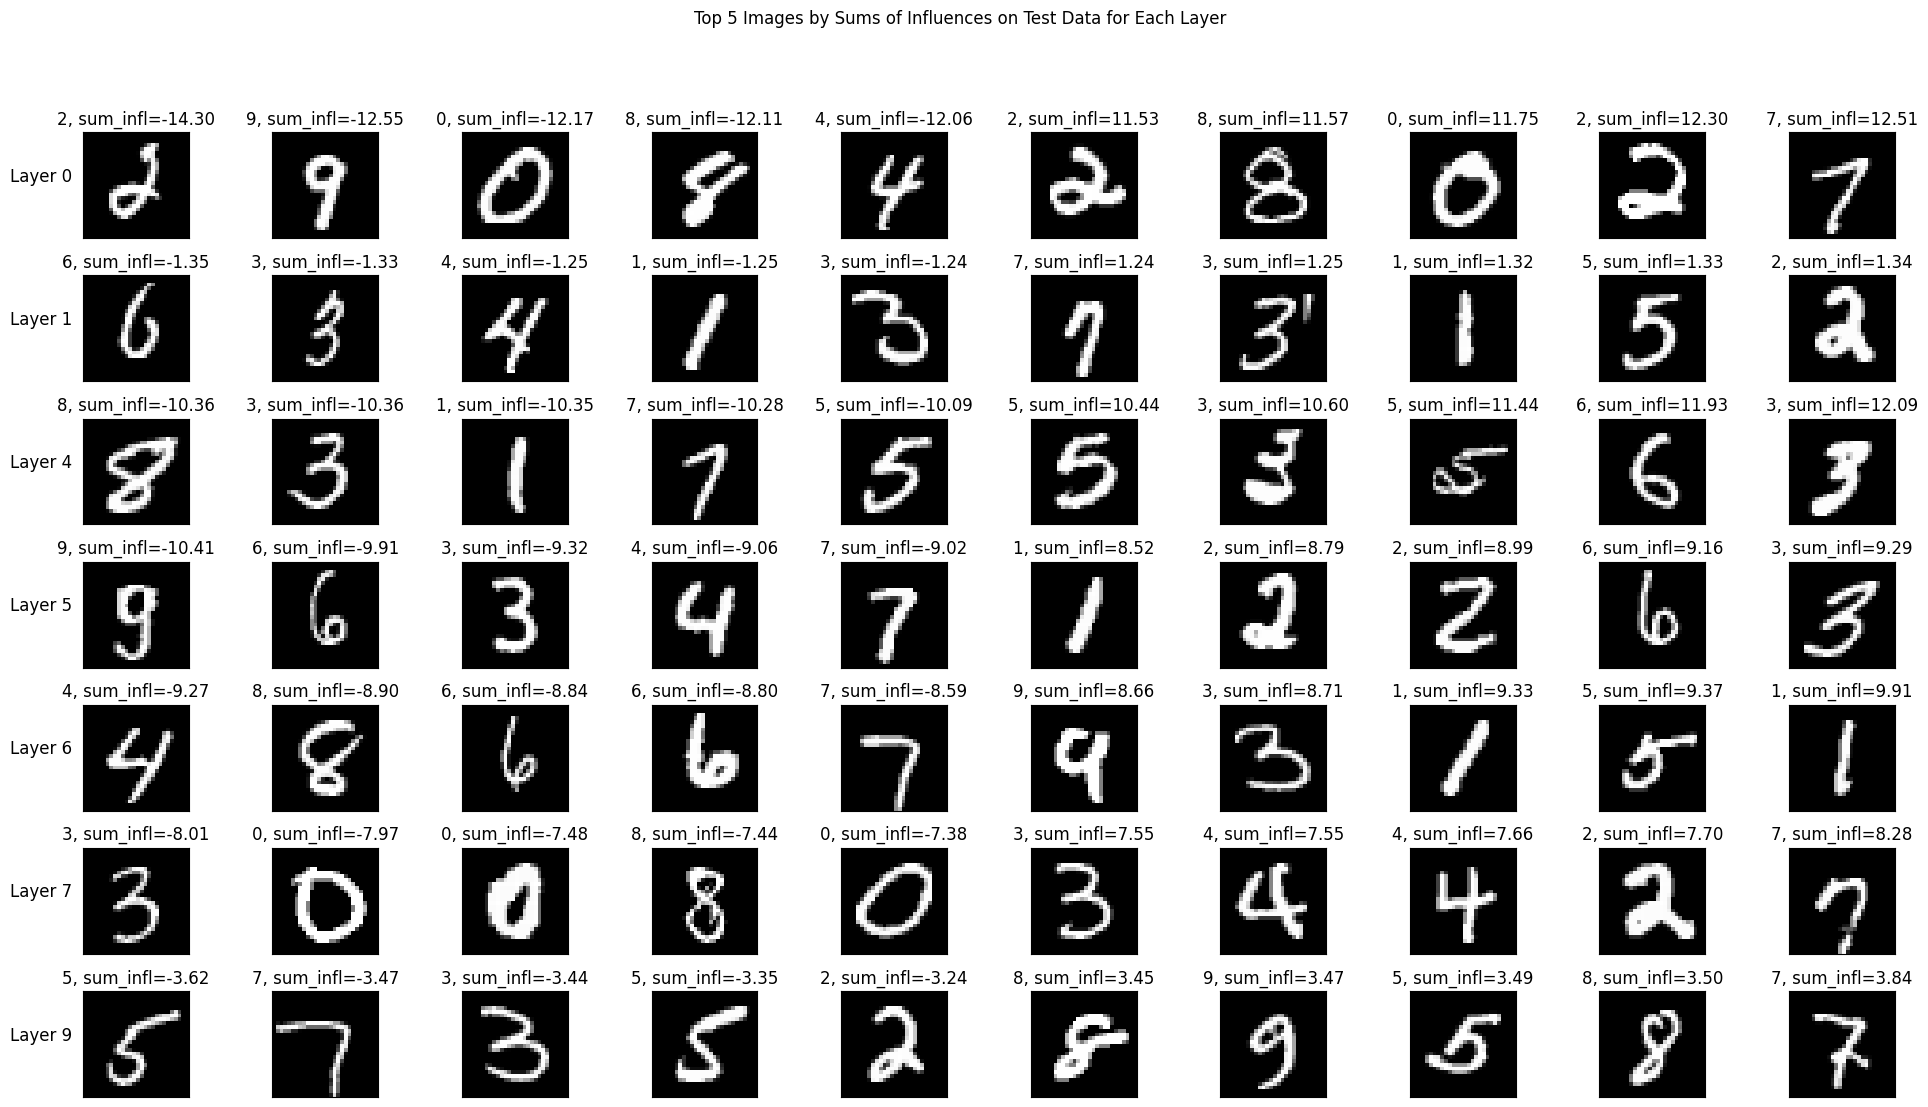

In [65]:
display_top_images(5, test_layer_to_sums, test_layer_to_sums_indicies)

In [15]:
def get_top_k_indicies_2d(a, k):
    v, i = torch.topk(a.flatten(), k)
    v2, i2 = torch.topk((-a).flatten(), k)
    return np.concatenate([
        np.array(np.unravel_index(i.numpy(), a.shape)).T,
        np.array(np.unravel_index(i2.numpy(), a.shape)).T,
    ]), np.concatenate([
        v,
        -v2,
    ])


def get_top_k_pairs(layer, k, layer_to_topks, layer_to_topks_indicies):
    idx, values = get_top_k_indicies_2d(layer_to_topks[layer], k)
    indicies_matrix = layer_to_topks_indicies[layer]
    #return idx, values, indicies_matrix
    influence_xs = (idx[:, 0] / 2).astype(np.int64)
    #return indicies_matrix
    influence_ys = indicies_matrix[idx[:, 0], idx[:, 1]]
    return influence_xs, influence_ys.numpy().astype(np.int64), values

Layer 0
Layer 1
Layer 4
Layer 5
Layer 6
Layer 7
Layer 9


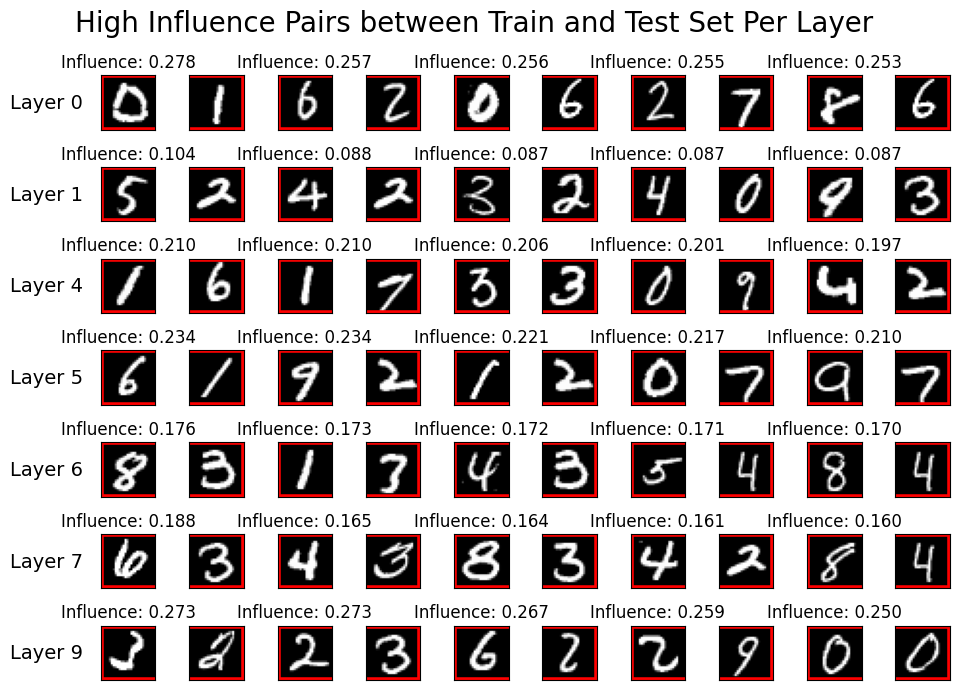

In [50]:
import matplotlib.patches as patches

def plot_top_k_pairs(j, layer, top_k, layer_to_topks, layer_to_topks_indicies, axes, per_row=5, line_width=10):
    # Call the get_top_k_pairs method
    idx1, idx2, influence_values = get_top_k_pairs(layer, top_k, layer_to_topks, layer_to_topks_indicies)

    for i in range(0, 2 * top_k, 2):
        row = i // (per_row * 2)
        col = (i % (per_row * 2))
        ind = i // 2

        # Get the images from the train dataset using the indices
        img1 = train.data[idx1[ind]]
        img2 = train.data[idx2[ind]]

        # Plot the images side by side
        axes[j + row, col].imshow(img1, cmap='gray')
        axes[j + row, col+1].imshow(img2, cmap='gray')

        # Remove axis labels
        axes[j + row, col].set_xticks([])
        axes[j + row, col].set_yticks([])
        axes[j + row, col+1].set_xticks([])
        axes[j + row, col+1].set_yticks([])

        # Display the influence value above the pair of images
        influence_value = influence_values[ind]
        axes[j + row, col].set_title(f"Influence: {influence_value:.3f}", fontsize=12)
        
        # Add a rectangle around each pair of images
        pair_rect1 = patches.Rectangle((0, 0), 1.5, 1, linewidth=line_width, edgecolor='r', facecolor='none', transform=axes[j + row, col].transAxes)
        pair_rect2 = patches.Rectangle((-.5, 0), 1.5, 1, linewidth=line_width, edgecolor='r', facecolor='none', transform=axes[j + row, col+1].transAxes)
        axes[j + row, col].add_patch(pair_rect1)
        axes[j + row, col+1].add_patch(pair_rect2)

def plot_all_layers(layer_to_sums_indicies, top_k, test_layer_to_topks, test_layer_to_topks_indicies, per_row=5, line_width=4):
    num_layers = len(layer_to_sums_indicies.keys())
    num_rows = (top_k) // (per_row)
    fig, axes = plt.subplots(nrows=num_rows * num_layers, ncols=2 * per_row, figsize=(2 * top_k, num_rows * num_layers))
    #print(axes[0, 8])

    for i, layer in enumerate(layer_to_sums_indicies.keys()):
        print(f"Layer {layer}")
        plot_top_k_pairs(i, layer, top_k, test_layer_to_topks, test_layer_to_topks_indicies, axes, per_row=per_row, line_width=line_width)

    # Set title for the whole plot
    fig.suptitle("High Influence Pairs between Train and Test Set Per Layer", fontsize=20)

    # Add layer titles on the left side
    for layer_idx, layer in enumerate(layer_to_sums_indicies.keys()):
        axes[layer_idx * num_rows, 0].text(-1, 0.5, f"Layer {layer}", fontsize=14, ha='center', va='center', rotation='horizontal', transform=axes[layer_idx * num_rows, 0].transAxes)
    
    plt.tight_layout()
    plt.show()

plot_all_layers(test_layer_to_sums_indicies, 5, test_layer_to_topks, test_layer_to_topks_indicies, per_row=5, line_width=4)

# Now, Let's look at Memory

In [11]:
layer_to_memory = defaultdict(lambda : torch.tensor(data=[]))
layer_to_sums = defaultdict(lambda : torch.tensor(data=[]))
layer_to_sums_indicies = defaultdict(lambda : torch.tensor(data=[]))
layer_to_topks = defaultdict(lambda : torch.tensor(data=[]))
layer_to_topks_indicies = defaultdict(lambda : torch.tensor(data=[]))

batch_size = 10 * 1000
def cat(layer, el):
    return torch.cat((layer, el))

for layer in tqdm(range(len(list(model_ft.children()))), desc='Layer', position=1, leave=False):
    children = list(model_ft.children())
    nn_layer = children[layer]
    if len(list(nn_layer.parameters())) == 0:
        print(f'skipping {layer} bc no params')
        continue
        
    for lower in tqdm(range(0, 60000, batch_size), position=0):
        print(lower)
        lower, upper = lower, lower + batch_size

        path = get_agg_location(layer, lower, upper)
        print(path)
        try:
            d = torch.load(path)
        except Exception as e:
            print(f'error loading {path}: {e}')
            continue

        estimates_with = d['estimates_with']
        estimates_without = d['estimates_without']
        num_with = d['num_with']
        num_total = d['num_total']

        estimates_with = (estimates_with.T / num_with).T
        estimates_without = (estimates_without.T / (num_total - num_with)).T

        esimate_changes = estimates_with - estimates_without
        estimate_mem = torch.diag(esimate_changes, 0)
        
        esimate_changes_sum = torch.sum(esimate_changes, dim=1)

        values_top, indicies_top = esimate_changes_sum.topk(300)
        values_bot, indicies_bot = (-esimate_changes_sum).topk(300)
        values_topk, indicies_topk = esimate_changes.topk(300)
        values_botk, indicies_botk = (-esimate_changes).topk(300)
        values_botk *= -1
        values_bot *= -1
        
        layer_to_memory[layer] = cat(layer_to_memory[layer], estimate_mem)
        
        layer_to_sums[layer] = cat(layer_to_sums[layer], values_top) 
        layer_to_sums[layer] = cat(layer_to_sums[layer], values_bot) 
        layer_to_sums_indicies[layer] = cat(layer_to_sums_indicies[layer], indicies_top)
        layer_to_sums_indicies[layer] = cat(layer_to_sums_indicies[layer], indicies_bot)
        
        layer_to_topks[layer] = cat(layer_to_topks[layer], values_topk) 
        layer_to_topks[layer] = cat(layer_to_topks[layer], values_botk) 
        layer_to_topks_indicies[layer] = cat(layer_to_topks_indicies[layer], indicies_topk)
        layer_to_topks_indicies[layer] = cat(layer_to_topks_indicies[layer], indicies_botk)

Layer:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_0/agg_0_9999
10000
/mnt/d/WhyNeuralNetsFinal/layer_0/agg_10000_19999
20000
/mnt/d/WhyNeuralNetsFinal/layer_0/agg_20000_29999
30000
/mnt/d/WhyNeuralNetsFinal/layer_0/agg_30000_39999
40000
/mnt/d/WhyNeuralNetsFinal/layer_0/agg_40000_49999
50000
/mnt/d/WhyNeuralNetsFinal/layer_0/agg_50000_59999


  0%|          | 0/6 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_1/agg_0_9999
10000
/mnt/d/WhyNeuralNetsFinal/layer_1/agg_10000_19999
20000
/mnt/d/WhyNeuralNetsFinal/layer_1/agg_20000_29999
30000
/mnt/d/WhyNeuralNetsFinal/layer_1/agg_30000_39999
40000
/mnt/d/WhyNeuralNetsFinal/layer_1/agg_40000_49999
50000
/mnt/d/WhyNeuralNetsFinal/layer_1/agg_50000_59999
skipping 2 bc no params
skipping 3 bc no params


  0%|          | 0/6 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_4/agg_0_9999
10000
/mnt/d/WhyNeuralNetsFinal/layer_4/agg_10000_19999
20000
/mnt/d/WhyNeuralNetsFinal/layer_4/agg_20000_29999
30000
/mnt/d/WhyNeuralNetsFinal/layer_4/agg_30000_39999
40000
/mnt/d/WhyNeuralNetsFinal/layer_4/agg_40000_49999
50000
/mnt/d/WhyNeuralNetsFinal/layer_4/agg_50000_59999


  0%|          | 0/6 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_5/agg_0_9999
10000
/mnt/d/WhyNeuralNetsFinal/layer_5/agg_10000_19999
20000
/mnt/d/WhyNeuralNetsFinal/layer_5/agg_20000_29999
30000
/mnt/d/WhyNeuralNetsFinal/layer_5/agg_30000_39999
40000
/mnt/d/WhyNeuralNetsFinal/layer_5/agg_40000_49999
50000
/mnt/d/WhyNeuralNetsFinal/layer_5/agg_50000_59999


  0%|          | 0/6 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_6/agg_0_9999
10000
/mnt/d/WhyNeuralNetsFinal/layer_6/agg_10000_19999
20000
/mnt/d/WhyNeuralNetsFinal/layer_6/agg_20000_29999
30000
/mnt/d/WhyNeuralNetsFinal/layer_6/agg_30000_39999
40000
/mnt/d/WhyNeuralNetsFinal/layer_6/agg_40000_49999
50000
/mnt/d/WhyNeuralNetsFinal/layer_6/agg_50000_59999


  0%|          | 0/6 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_7/agg_0_9999
10000
/mnt/d/WhyNeuralNetsFinal/layer_7/agg_10000_19999
20000
/mnt/d/WhyNeuralNetsFinal/layer_7/agg_20000_29999
30000
/mnt/d/WhyNeuralNetsFinal/layer_7/agg_30000_39999
40000
/mnt/d/WhyNeuralNetsFinal/layer_7/agg_40000_49999
50000
/mnt/d/WhyNeuralNetsFinal/layer_7/agg_50000_59999
skipping 8 bc no params


  0%|          | 0/6 [00:00<?, ?it/s]

0
/mnt/d/WhyNeuralNetsFinal/layer_9/agg_0_9999
10000
/mnt/d/WhyNeuralNetsFinal/layer_9/agg_10000_19999
20000
/mnt/d/WhyNeuralNetsFinal/layer_9/agg_20000_29999
30000
/mnt/d/WhyNeuralNetsFinal/layer_9/agg_30000_39999
40000
/mnt/d/WhyNeuralNetsFinal/layer_9/agg_40000_49999
50000
/mnt/d/WhyNeuralNetsFinal/layer_9/agg_50000_59999


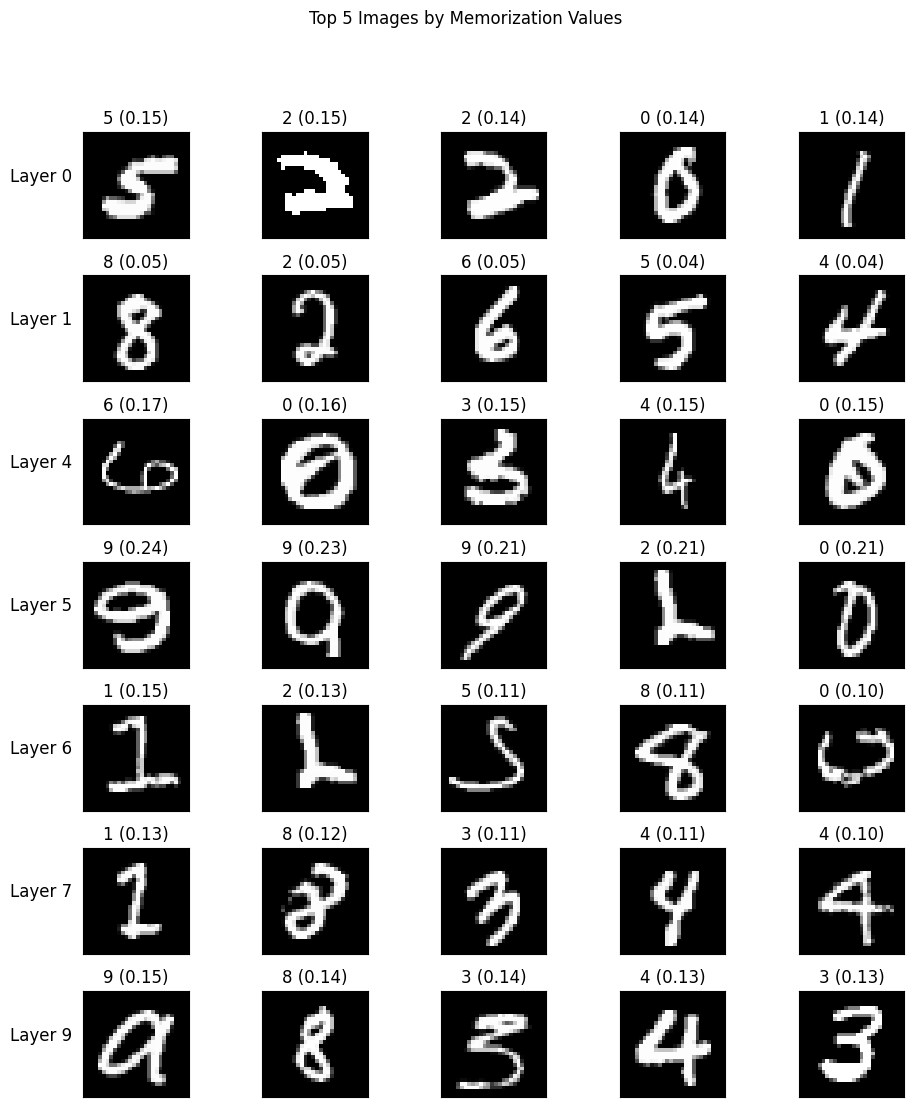

In [29]:
def display_top_images(num_top_images, layer_to_memory):
    num_layers = len(layer_to_memory)
    fig, axes = plt.subplots(num_layers, num_top_images, figsize=(num_top_images * 2, num_layers * 1.5))

    # Loop through each layer and display the top images
    for layer_idx, (layer, memory_values) in enumerate(layer_to_memory.items()):
        # Convert tensor to pandas DataFrame and sort by memory values
        df = pd.DataFrame(memory_values.numpy()).sort_values(by=0, ascending=False)

        # Get the top 5 images by index
        top_images = [(idx, val, train.data[idx].squeeze().numpy()) for idx, val in df.iloc[:num_top_images].itertuples()]

        # Display the images
        for i, (idx, val, img) in enumerate(top_images):
            axes[layer_idx, i].imshow(img, cmap='gray')
            axes[layer_idx, i].set_xticks([])
            axes[layer_idx, i].set_yticks([])
            axes[layer_idx, i].set_title(f'{train.targets[idx]} ({val:.2f})')
            if i == 0:
                axes[layer_idx, i].set_ylabel(f'Layer {layer}', rotation=0, fontsize=12, labelpad=30)

    plt.suptitle(f'Top {num_top_images} Images by Memorization Values', y=1.05)
    plt.tight_layout()
    plt.show()

# Call the function with your layer_to_memory dictionary
display_top_images(5, layer_to_memory)

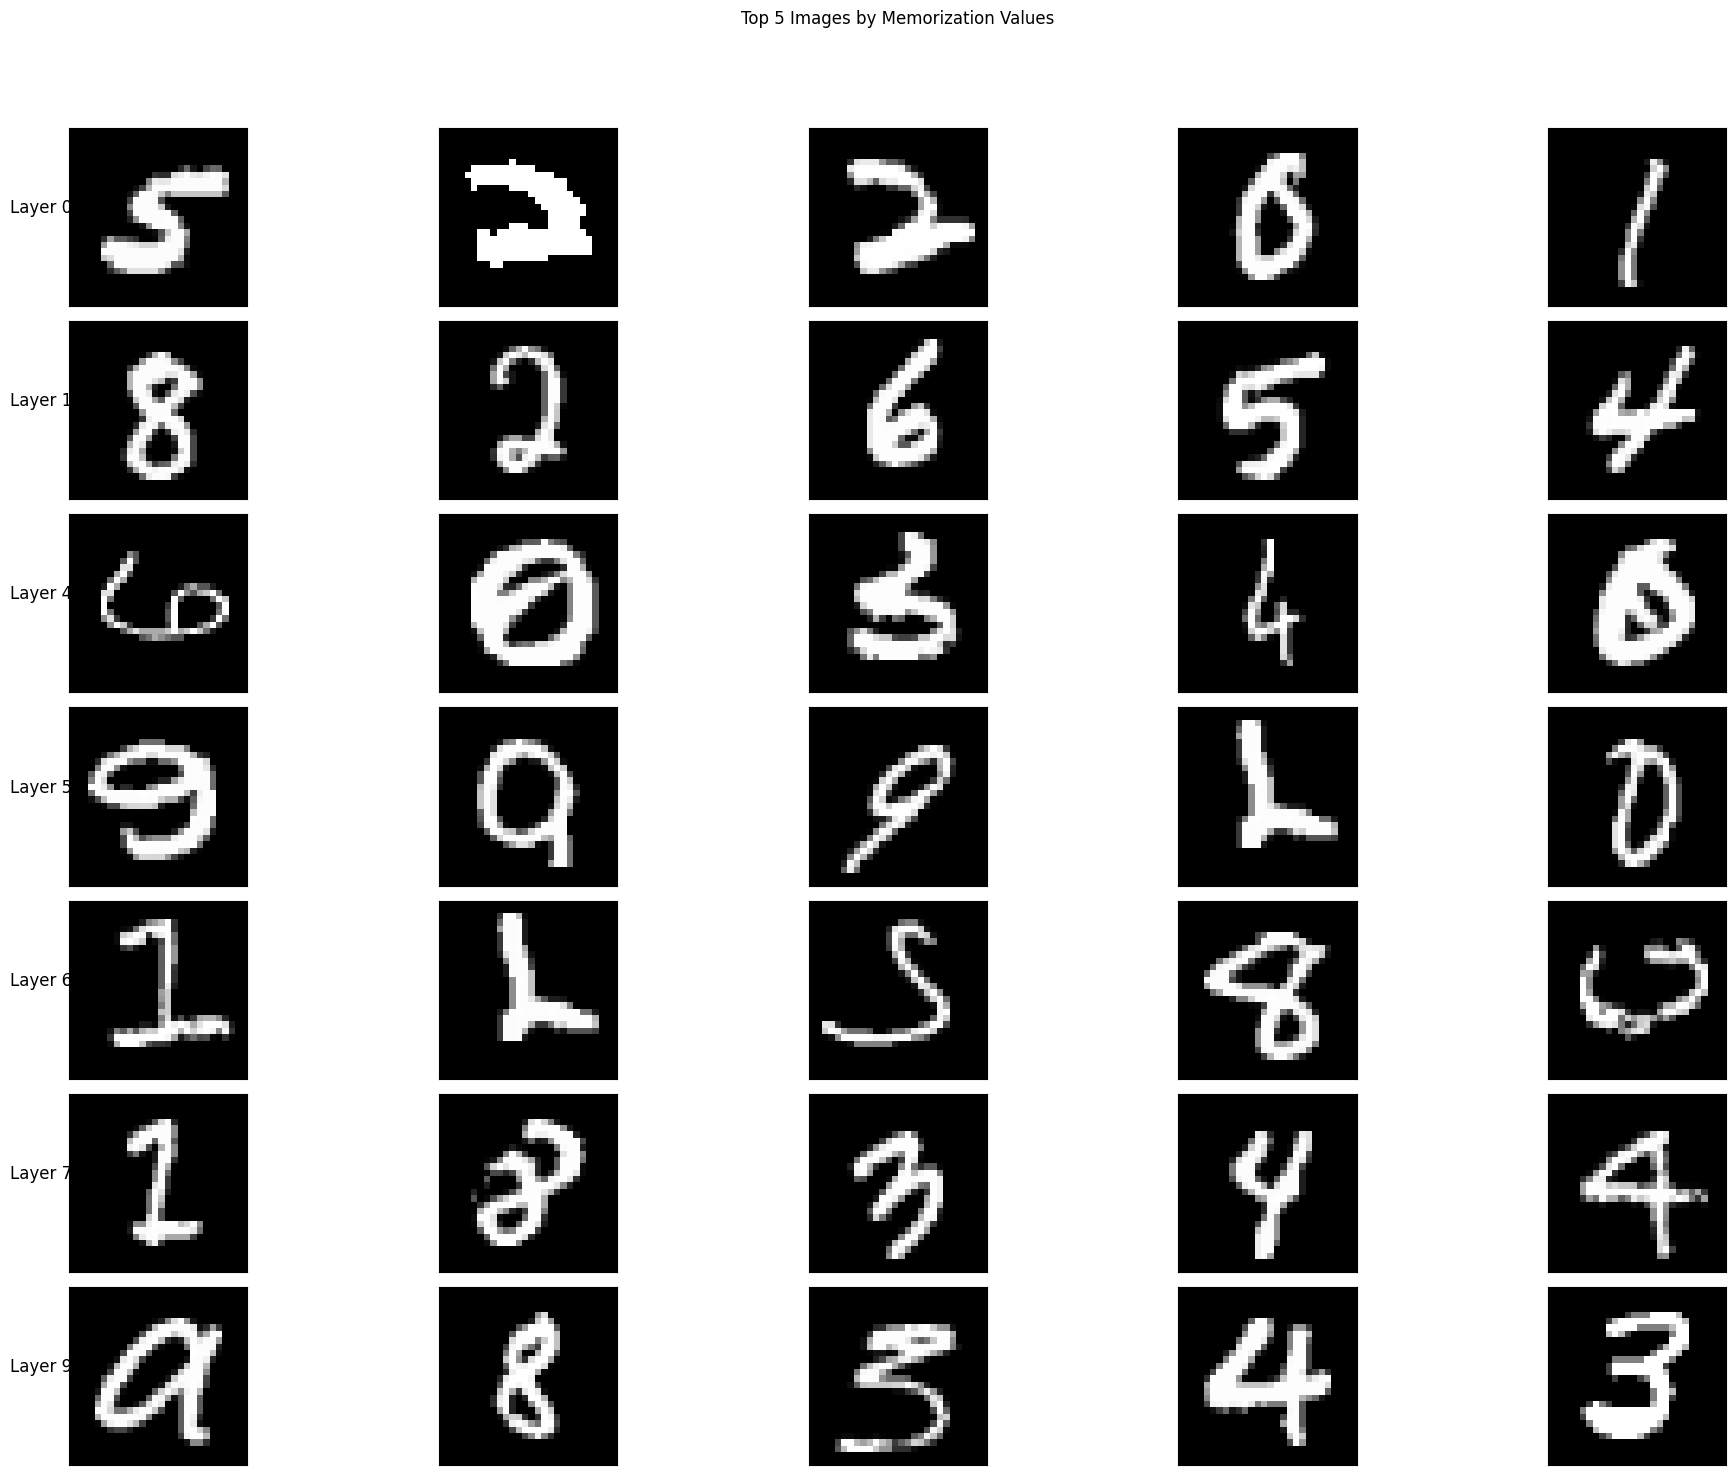

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def display_top_images(num_top_images, layer_to_memory):
    num_layers = len(layer_to_memory)

    # Loop through each layer and display the top images
    for layer, memory_values in layer_to_memory.items():
        # Convert tensor to pandas DataFrame and sort by memory values
        df = pd.DataFrame(memory_values.numpy()).sort_values(by=0, ascending=False)
        
        fig, axes = plt.subplots(1, num_top_images, figsize=(num_top_images * 4, 2))

        # Get the top 5 images by index
        top_images = [(idx, val, train.data[idx].squeeze().numpy()) for idx, val in df.iloc[:num_top_images].itertuples()]

        # Display the images
        for i, (idx, val, img) in enumerate(top_images):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            axes[i].set_title(f'{train.targets[idx]} ({val:.2f})')

        plt.suptitle(f'Top {num_top_images} Images by Memorization Values for Layer {layer}', y=1.05)
        plt.tight_layout()
        plt.show()

# Call the function with your layer_to_memory dictionary
display_top_images(5, layer_to_memory)

In [12]:
def get_gt(mem, gt):
    return ((mem > gt) | (mem < -gt)).nonzero(), mem[(mem > gt) | (mem < -gt)]

def get_topk(mem):
    topk_val, topk_ind = mem.topk(10)
    botk_val, botk_ind = (-mem).topk(10)
    botk_val *= -1
    return (topk_ind, topk_val), (botk_ind, botk_val)

layer_to_topk = {
    layer: get_topk(mem) for layer, mem in layer_to_memory.items()
}

def get_gt_layers(gt):
    return {
        layer: get_gt(mem, gt) for layer, mem in layer_to_memory.items()
    }

In [13]:
def intersection(tensors):
    """
    Computes the 1D intersection of the elements in a list of PyTorch tensors.

    Args:
        tensors (list): A list of PyTorch tensors.

    Returns:
        intersection (torch.Tensor): A 1D tensor containing the intersection of the elements.
    """
    intersection = set(tensors[0])
    print(len(intersection))
    for tensor in tensors[1:]:
        intersection = intersection.intersection(set(tensor))
        print(len(intersection))
    return torch.tensor(list(intersection))

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from upsetplot import from_contents

# Compute Jaccard similarity matrix
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if len(set1) == 0 or len(set2) == 0:
        return 0
    return intersection / union

def visualize_gt(gt):
    gt_map = get_gt_layers(gt)
    sets = [set(flatten(tensor[0].tolist())) for tensor in gt_map.values()]
    
    similarity_matrix = np.zeros((len(sets), len(sets)))
    for i in range(len(sets)):
        for j in range(len(sets)):
            similarity_matrix[i, j] = jaccard_similarity(sets[i], sets[j])

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        similarity_matrix, annot=True, cmap="coolwarm", 
        xticklabels=[f'Layer {i}' for i in gt_map.keys()],
        yticklabels=[f'Layer {i}' for i in gt_map.keys()],
    )
    plt.title("Jaccard Similarity Heatmap")
    plt.show()
    
def visualize_gt_upset(gt):
    gt_map = get_gt_layers(gt)
    sets = [set(flatten(tensor[0].tolist())) for tensor in gt_map.values()]

    df = from_contents({f'Layer {i}': list(s) for i, s in zip(gt_map.keys(), sets)})
    # Plot UpSet plot
    upset = UpSet(df, show_counts=True)
    upset.plot()
    plt.title("UpSet Plot for Layer Memorization Similarity")
    plt.show()

In [15]:
def flatten(l):
    return [i for j in l for i in j]

In [16]:
from mpl_toolkits.mplot3d import Axes3D

def add_bar_counts(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{height}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom'
        )

def visualize_multi_gts(gt_values):
    n_gt = len(gt_values)
    
     # Initialize empty list to store set sizes
    set_sizes = []

    fig, axes = plt.subplots(1, n_gt, figsize=(8 * n_gt, 10), sharey=True)

    wspace = .02
    fig.subplots_adjust(wspace=wspace)

    for idx, gt in enumerate(gt_values):
        gt_map = get_gt_layers(gt)
        sets = [set(flatten(tensor[0].tolist())) for tensor in gt_map.values()]
        
        # Store set sizes
        set_sizes.append([len(s) for s in sets])

        similarity_matrix = np.zeros((len(sets), len(sets)))
        for i in range(len(sets)):
            for j in range(len(sets)):
                similarity_matrix[i, j] = jaccard_similarity(sets[i], sets[j])

        # Heatmap
        sns.heatmap(
            similarity_matrix, annot=True, cmap="coolwarm", 
            xticklabels=[f'Layer {i}' for i in gt_map.keys()],
            yticklabels=[f'Layer {i}' for i in gt_map.keys()],
            ax=axes[idx], cbar=idx == len(gt_values) - 1
        )
        axes[idx].set_title(f"Jaccard Similarity Heatmap for Memorization Threshold {gt}")
    
    # Set Sizes Bar Plot for each gt_value
    fig2, axes2 = plt.subplots(1, n_gt, figsize=(8 * n_gt, 6), sharey=True)
    fig2.subplots_adjust(wspace=wspace)
    
    # Define color palette based on the number of layers
    num_layers = len(get_gt_layers(gt_values[0]))
    colors = sns.color_palette("husl", num_layers)

    # Set Sizes Bar Plot
    for idx, gt in enumerate(gt_values):
        gt_map = get_gt_layers(gt)
        sets = [set(flatten(tensor[0].tolist())) for tensor in gt_map.values()]
        set_sizes = [len(s) for s in sets]

        set_sizes_df = pd.DataFrame(set_sizes, index=[f'Layer {i}' for i in gt_map.keys()], columns=[f'Memorization Threshold {gt}']).T
        bar_plot = set_sizes_df.plot(kind='bar', ax=axes2[idx], rot=0, legend=True, width=5)
        axes2[idx].set_title(f"Set Sizes for Memorization Threshold {gt}")
        axes2[idx].set_xlabel("Layers")
        if idx == 0:
            axes2[idx].set_ylabel("Set Size")
        else:
            axes2[idx].get_legend().remove()
        
        # Add counts above the bars
        for container in bar_plot.containers:
            add_bar_counts(axes2[idx], container)

    plt.show()
    plt.close(plt.tight_layout())
    plt.close(fig2)
    

In [17]:
from math import prod

In [18]:
def get_num_params(mod):
    num = 0
    for p in mod.parameters():
        num += prod(p.shape)
    return num

In [19]:
layer_to_number_of_parameters = {}
for layer in tqdm(range(len(list(model_ft.children()))), desc='Layer', position=1, leave=False):
    children = list(model_ft.children())
    nn_layer = children[layer]
    if len(list(nn_layer.parameters())) == 0:
        print(f'skipping {layer} bc no params')
        continue
    layer_to_number_of_parameters[layer] = get_num_params(nn_layer)

Layer:   0%|          | 0/10 [00:00<?, ?it/s]

skipping 2 bc no params
skipping 3 bc no params
skipping 8 bc no params


# Let's Look at # Memorized vs # of Parameters

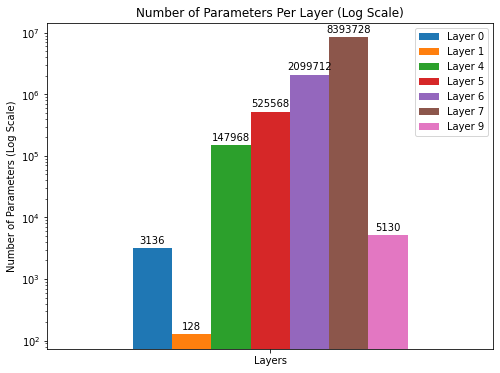

In [51]:
num_layers = len(layer_to_number_of_parameters)
colors = sns.color_palette("husl", num_layers)

# Assign colors to layers based on their index
#layer_colors = [colors[i] for i in layer_to_number_of_parameters.keys()]

set_sizes_df = pd.DataFrame(list(layer_to_number_of_parameters.values()), index=[f'Layer {i}' for i in layer_to_number_of_parameters.keys()], columns=['Layers']).T
bar_plot = set_sizes_df.plot(kind='bar', rot=0, legend=True, width=0.8, figsize=(8, 6), logy=True)

plt.title("Number of Parameters Per Layer (Log Scale)")
#plt.xlabel("Layer Number")
plt.ylabel("Number of Parameters (Log Scale)")

# Add counts above the bars
for container in bar_plot.containers:
    add_bar_counts(bar_plot, container)

plt.show()

In [49]:
def get_num_memorized(layer, threshold) -> int:
    gt_map = get_gt_layers(threshold)
    return len(set(flatten(gt_map[layer][0].tolist())))

layers = list(gt_map.keys())
thresholds = list(np.arange(.01, .2, 0.005))

In [50]:
# Create an empty DataFrame to store the data
data = []

# Loop through the layers and thresholds, calling get_num_memorized and storing the results in data
for layer in layers:
    for threshold in thresholds:
        num_memorized = get_num_memorized(layer, threshold)
        data.append({"Layer": layer, "Threshold": threshold, "Num Memorized": num_memorized})

# Create a DataFrame from the data
df = pd.DataFrame(data)

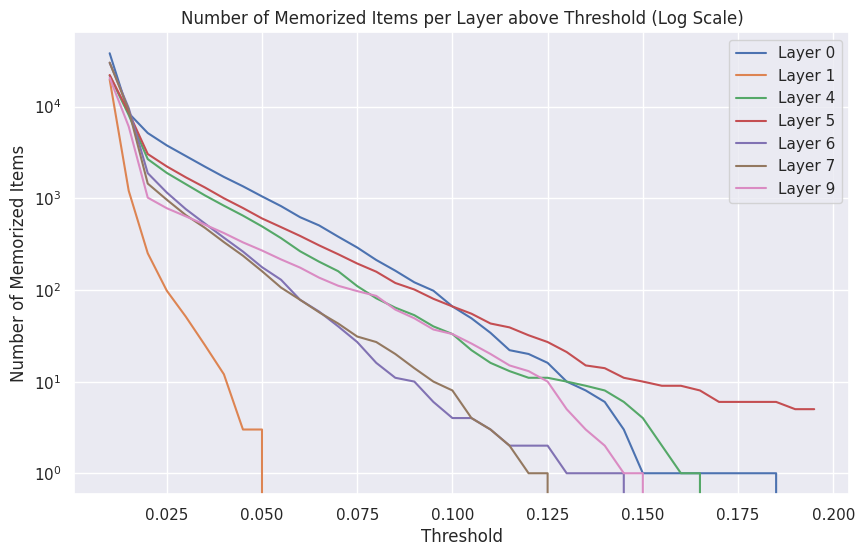

In [88]:
# Create a new figure and set its size
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through the layers and plot a line for each layer
for layer in layers:
    layer_data = df[df["Layer"] == layer]
    ax.plot(layer_data["Threshold"], layer_data["Num Memorized"], label=f"Layer {layer}")

# Set the title and labels of the graph
ax.set_title("Number of Memorized Items per Layer above Threshold (Log Scale)")
ax.set_xlabel("Threshold")
ax.set_ylabel("Number of Memorized Items")

# Set the y-axis scale to log
ax.set_yscale("log")

# Add a legend
ax.legend()

# Show the graph
plt.show()

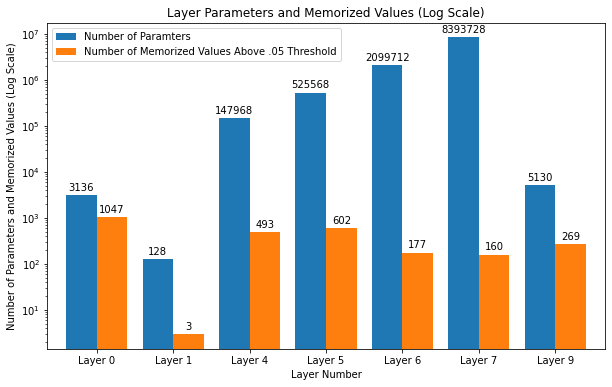

In [49]:
num_layers = len(layer_to_number_of_parameters)

gt_map = get_gt_layers(.05)
layer_to_num_elems = {k: len(set(flatten(tensor[0].tolist()))) for k, tensor in gt_map.items()}

colors = sns.color_palette("husl", num_layers)

data_df  = pd.DataFrame({
    'Number of Paramters': layer_to_number_of_parameters.values(),
    'Number of Memorized Values Above .05 Threshold': layer_to_num_elems.values()
}, index=[f'Layer {i}' for i in layer_to_number_of_parameters.keys()])

bar_plot = data_df.plot(kind='bar', rot=0, legend=True, width=0.8, figsize=(10, 6), logy=True)

plt.title("Layer Parameters and Memorized Values (Log Scale)")
plt.xlabel("Layer Number")
plt.ylabel("Number of Parameters and Memorized Values (Log Scale)")

# Add counts above the bars
for container in bar_plot.containers:
    add_bar_counts(bar_plot, container)

plt.show()

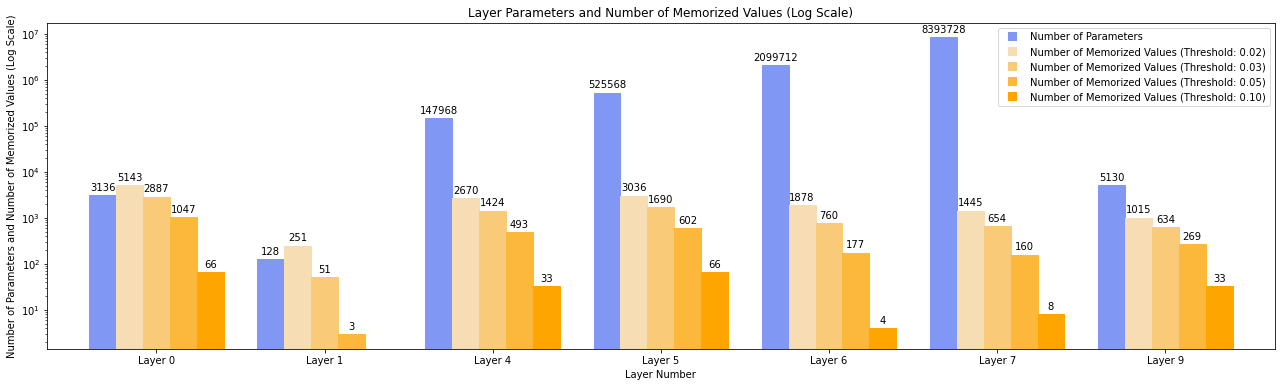

In [50]:
from matplotlib.lines import Line2D

def visualize_params_memorized_values(gt_values):
    num_layers = len(layer_to_number_of_parameters)
    colors = sns.color_palette("husl", num_layers)

    # Initialize an empty dictionary to store the number of memorized values per layer for each threshold
    memorized_values_data = {}

    for gt in gt_values:
        gt_map = get_gt_layers(gt)
        layer_to_num_elems = {k: len(set(flatten(tensor[0].tolist()))) for k, tensor in gt_map.items()}
        memorized_values_data[f'Number of Memorized Values (Threshold: {gt:.2f})'] = layer_to_num_elems.values()

    # Combine the number of parameters and the memorized values data into a single DataFrame
    data_df = pd.DataFrame({'Number of Parameters in Layer': layer_to_number_of_parameters.values(), **memorized_values_data},
                           index=[f'Layer {i}' for i in layer_to_number_of_parameters.keys()])

    # Create a bar plot with log scale on the y-axis
    ax = data_df.plot(kind='bar', rot=0, legend=True, width=0.8, figsize=(22, 6), logy=True)

    for i in range(len(layer_to_number_of_parameters)):
        ax.containers[0][i].set_color(colors[5])

    # Use shades of orange for the thresholded columns
    threshold_colors = sns.light_palette("orange", n_colors=len(gt_values) + 1)[1:]
    for idx, container in enumerate(ax.containers[1:], start=0):
        for i in range(len(layer_to_number_of_parameters)):
            container[i].set_color(threshold_colors[idx])

    plt.title("Layer Parameters and Number of Memorized Values (Log Scale)")
    plt.xlabel("Layer Number")
    plt.ylabel("Number of Parameters and Number of Memorized Values (Log Scale)")

    # Add counts above the bars
    for container in ax.containers:
        add_bar_counts(ax, container)

    legend_elements = [Line2D([0], [0], marker='s', color='w', label='Number of Parameters', markerfacecolor=colors[5], markersize=10)] + \
                      [Line2D([0], [0], marker='s', color='w', label=f'Number of Memorized Values (Threshold: {gt:.2f})', markerfacecolor=threshold_colors[idx], markersize=10) for idx, gt in enumerate(gt_values)]

    ax.legend(handles=legend_elements, loc='best')

    plt.show()

# Call the function with a list of threshold values
visualize_params_memorized_values([2e-2, 3e-2, 5e-2, 1e-1])

# Let's look at the influential points

In [ ]:
layer_to_sums = defaultdict(lambda : torch.tensor(data=[]))
layer_to_sums_indicies = defaultdict(lambda : torch.tensor(data=[]))
layer_to_topks = defaultdict(lambda : torch.tensor(data=[]))
layer_to_topks_indicies = defaultdict(lambda : torch.tensor(data=[]))

In [58]:
def display_top_images(num_top_images, layer_to_sums, layer_to_sums_indicies):
    num_layers = len(layer_to_sums_indicies)

    # Loop through each layer and display the top images
    for layer, top_indices in layer_to_sums_indicies.items():
        top_sums = layer_to_sums[layer]
        df = pd.DataFrame(top_sums.numpy(), index=top_indices.long().numpy()).sort_values(by=0)
        fig, axes = plt.subplots(1, num_top_images * 2, figsize=(num_top_images * 4, 2))

        top_n = df[0].iloc[:num_top_images]
        bottom_n = df[0].iloc[-num_top_images:]
        # Get the top 10 images by index
        top_images = [(idx, val, train.data[idx].squeeze().numpy()) for idx, val in pd.concat([top_n, bottom_n]).items()]

        # Display the images
        for i, (idx, val, img) in enumerate(top_images):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            axes[i].set_title(f'Image {idx + 1} ({val:.2f})')

        plt.suptitle(f'Top {num_top_images} Images by Sums for Layer {layer}', y=1.05)
        plt.tight_layout()
        plt.show()

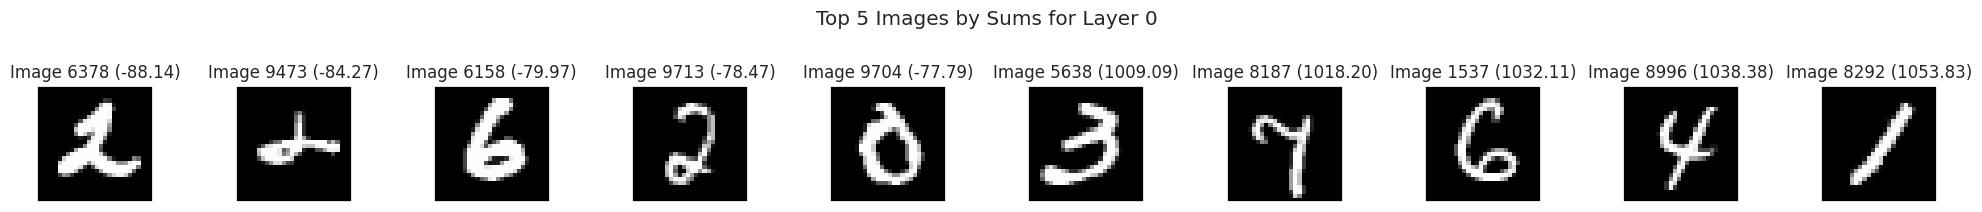

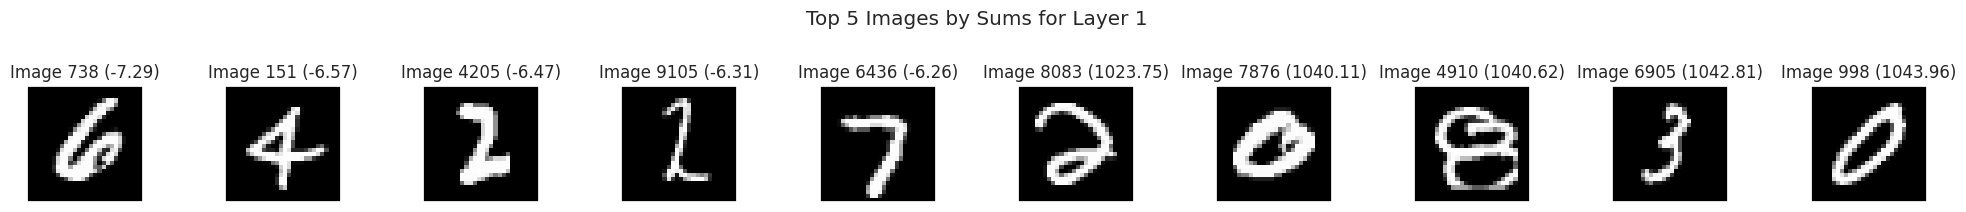

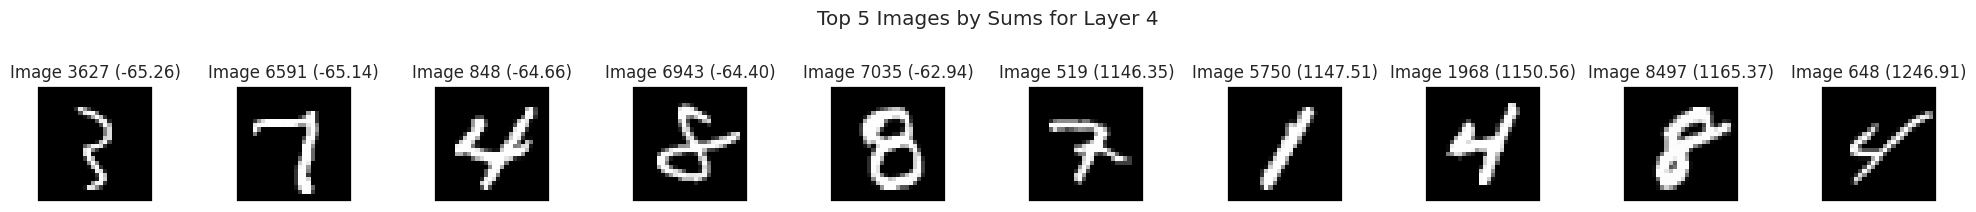

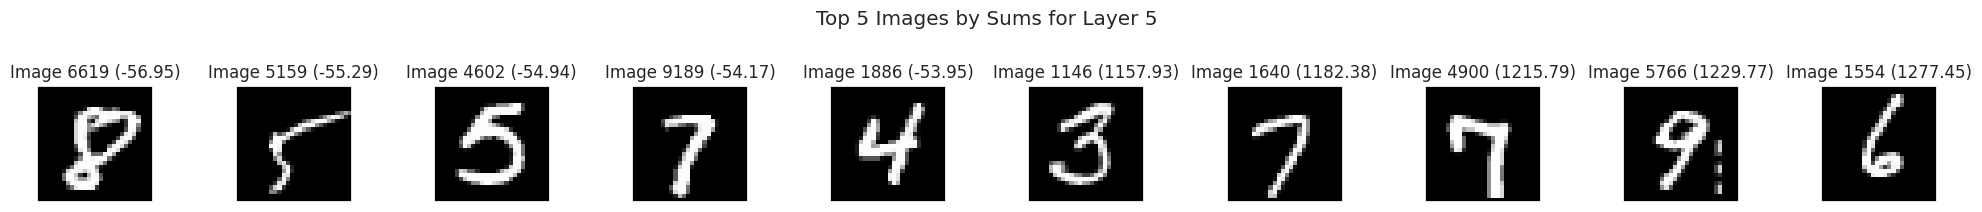

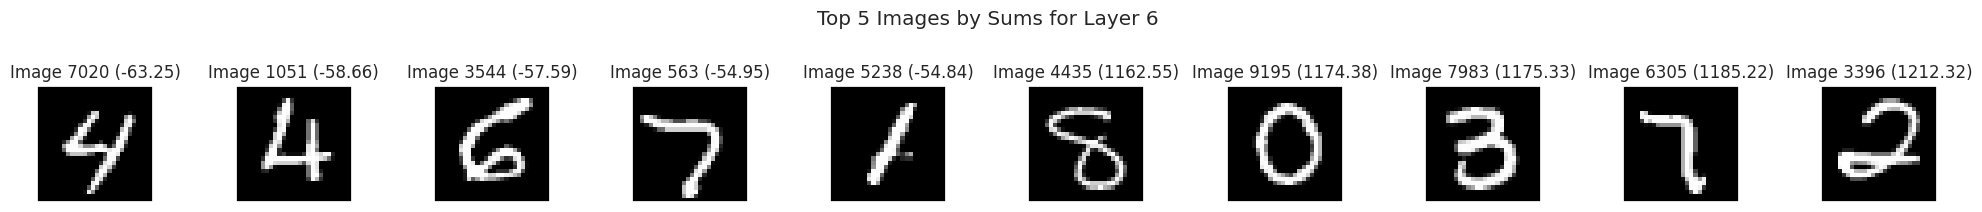

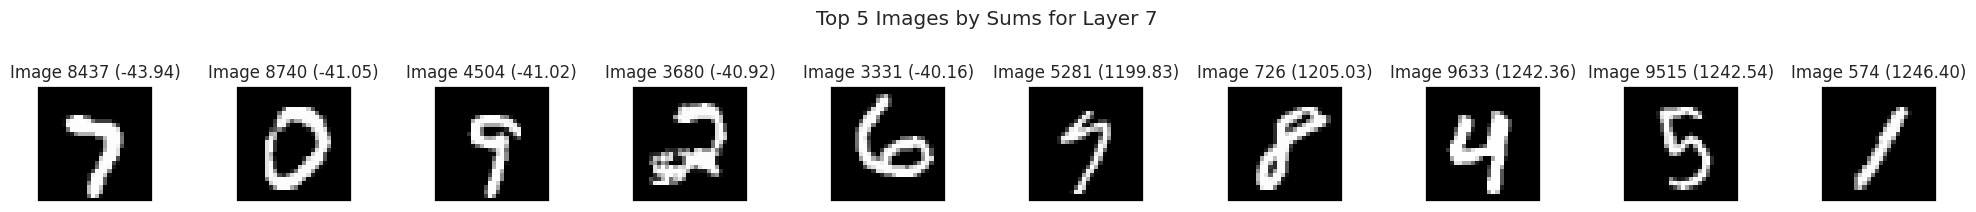

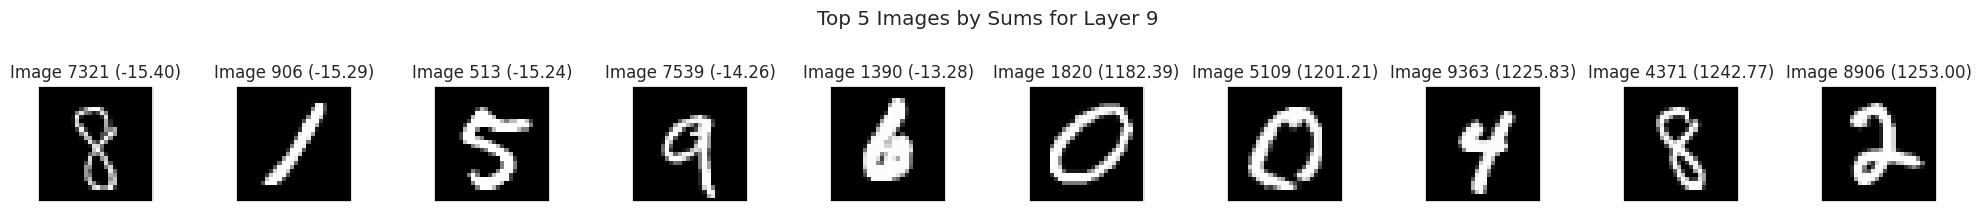

In [59]:
# Call the function
res = display_top_images(5, layer_to_sums, layer_to_sums_indicies)

In [86]:
import math

def display_top_images(num_top_images, layer_to_sums, layer_to_sums_indicies, dataset=train):
    num_layers = len(layer_to_sums_indicies)
    
    # Calculate the number of rows and columns for the subplots
    subplot_columns = num_top_images * 2
    subplot_rows = num_layers
    
    # Create a single figure with multiple subplots for all the layers
    fig, axes = plt.subplots(subplot_rows, subplot_columns, figsize=(2 * subplot_columns, subplot_rows * 1.5))
    
    # Loop through each layer and display the top images
    for row, (layer, top_indices) in enumerate(layer_to_sums_indicies.items()):
        top_sums = layer_to_sums[layer]
        df = pd.DataFrame(top_sums.numpy(), index=top_indices.long().numpy()).sort_values(by=0)
        
        top_n = df[0].iloc[:num_top_images]
        bottom_n = df[0].iloc[-num_top_images:]
        # Get the top 10 images by index
        top_images = [(idx, val, train.data[idx].squeeze().numpy()) for idx, val in pd.concat([top_n, bottom_n]).items()] #, #bottom_n]).items()]

        # Display the images
        for col, (idx, val, img) in enumerate(top_images):
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_title(f'{dataset.targets[idx].item()}, sum_infl={val:.2f}')

        # Add a title for each row (layer)
        axes[row, 0].set_ylabel(f'Layer {layer}', rotation=0, size='large', labelpad=30)

    plt.suptitle(f'Top {num_top_images} Images by Sums of Influences on Train Data for Each Layer', y=1.05)
    plt.tight_layout()
    plt.show()

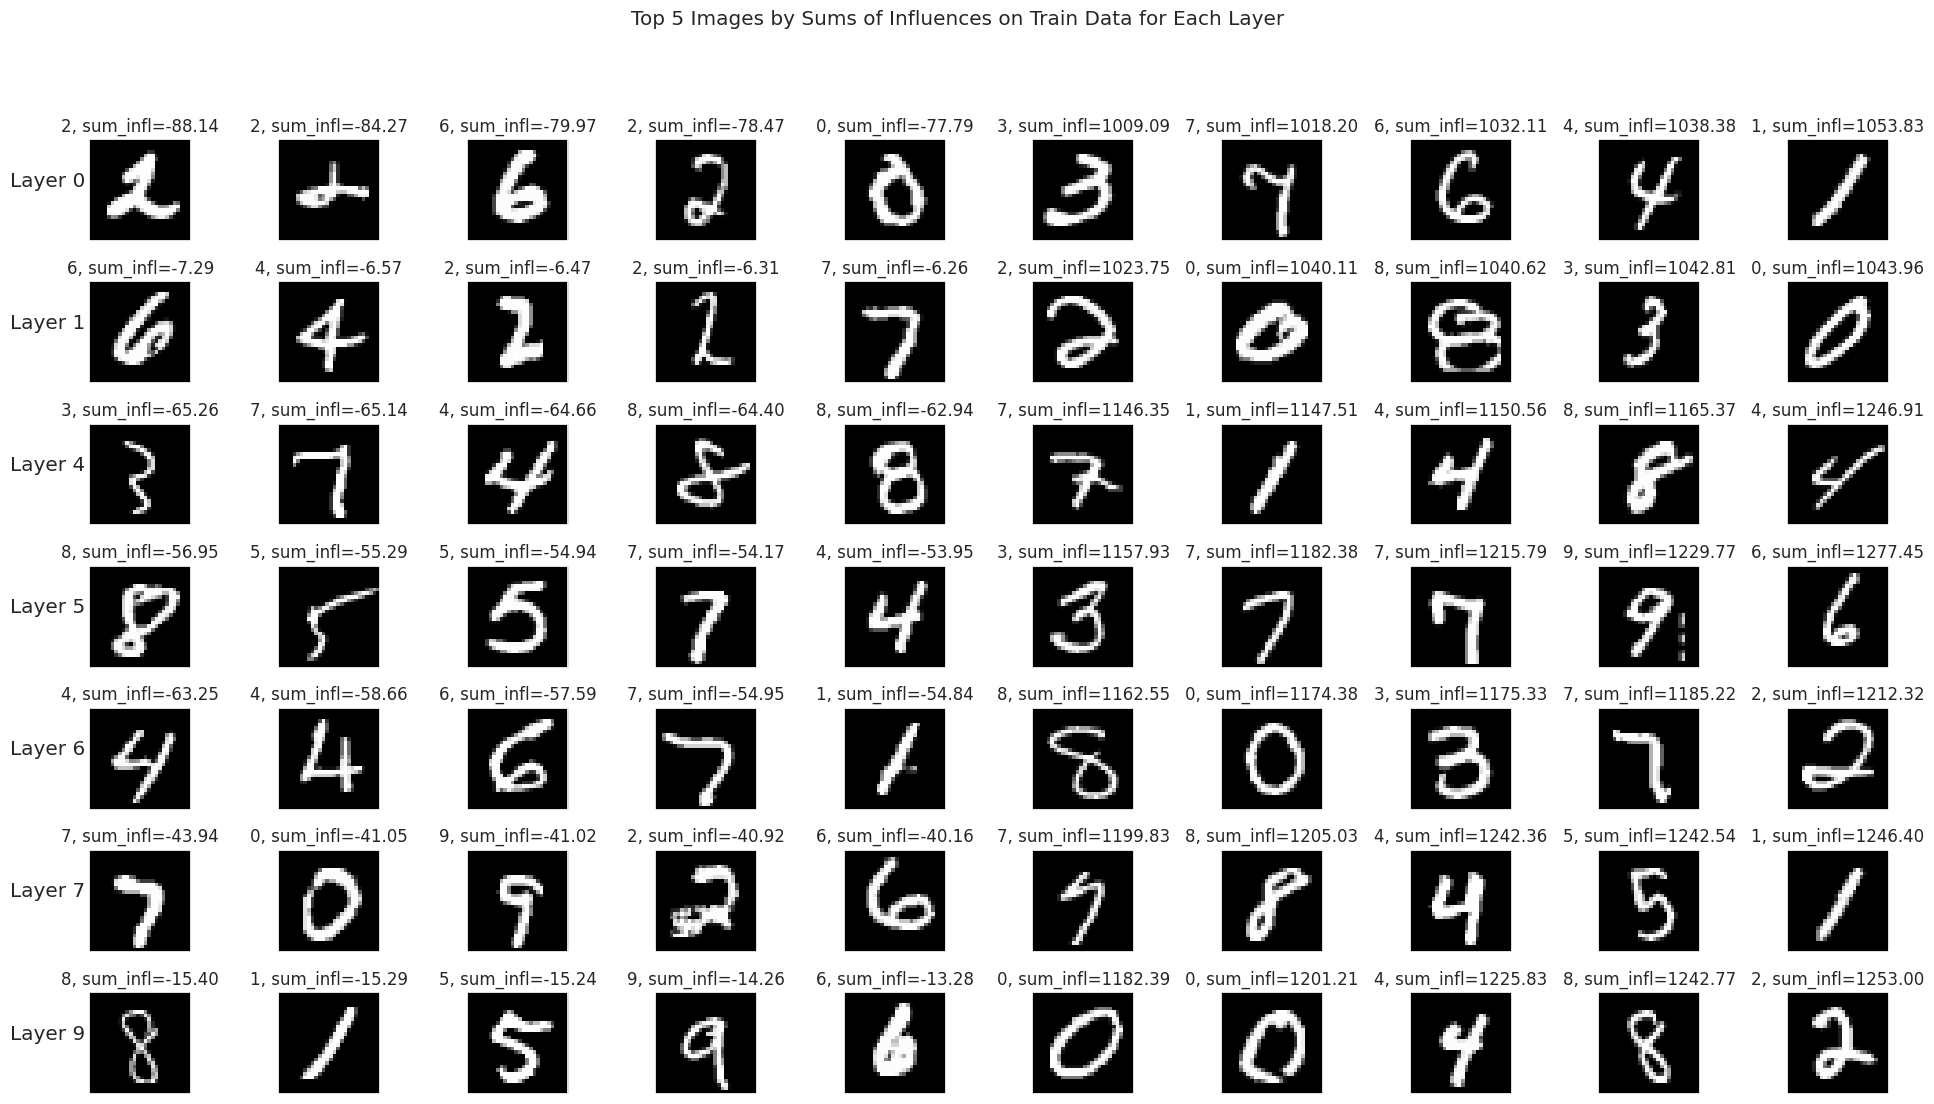

In [67]:
# Call the function
res = display_top_images(5, layer_to_sums, layer_to_sums_indicies)

In [70]:
def get_top_k_indicies_2d(a, k):
    v, i = torch.topk(a.flatten(), k)
    v2, i2 = torch.topk((-a).flatten(), k)
    return np.concatenate([
        np.array(np.unravel_index(i.numpy(), a.shape)).T,
        np.array(np.unravel_index(i2.numpy(), a.shape)).T,
    ]), np.concatenate([
        v,
        -v2,
    ])


def get_top_k_pairs(layer, k):
    idx, values = get_top_k_indicies_2d(layer_to_topks[layer], k)
    indicies_matrix = layer_to_topks_indicies[layer]
    
    influence_xs = (idx[:, 0] / 2).astype(np.int64)
    influence_ys = indicies_matrix[idx[:, 0], idx[:, 1]]
    return influence_xs, influence_ys.numpy().astype(np.int64), values

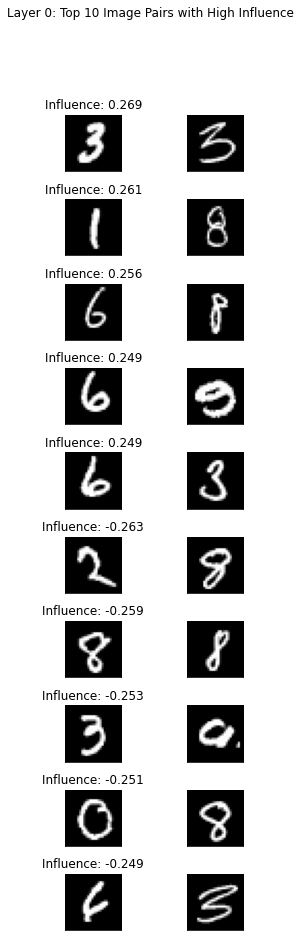

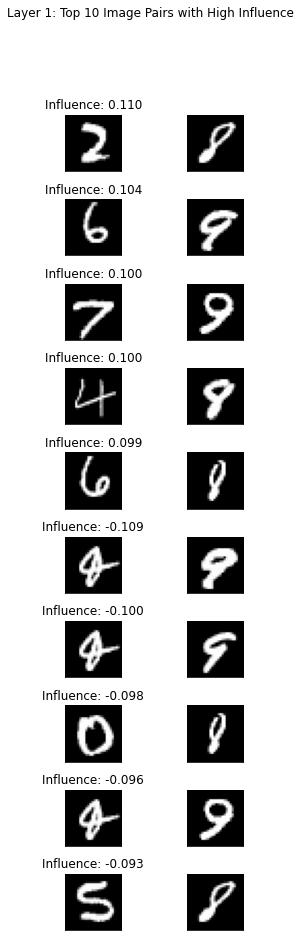

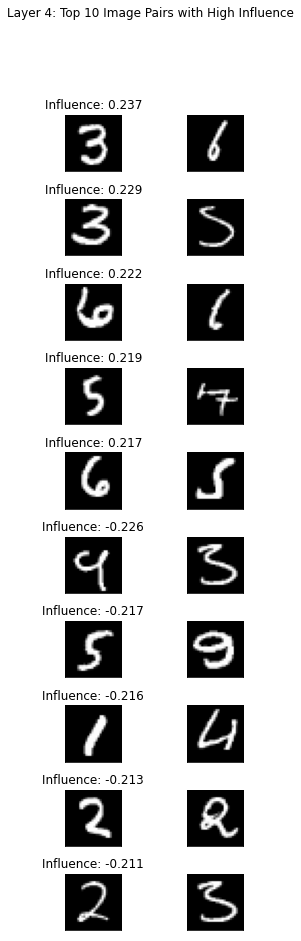

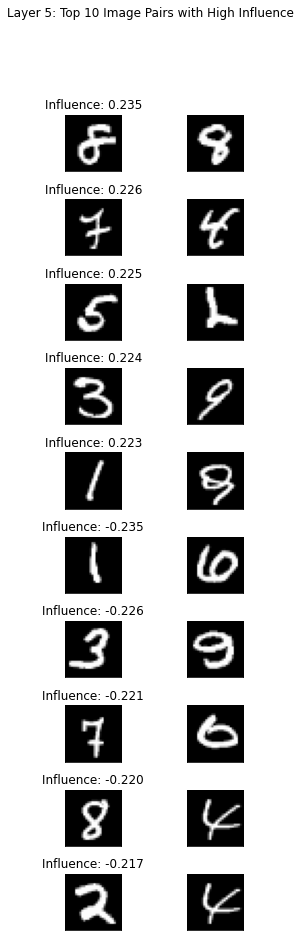

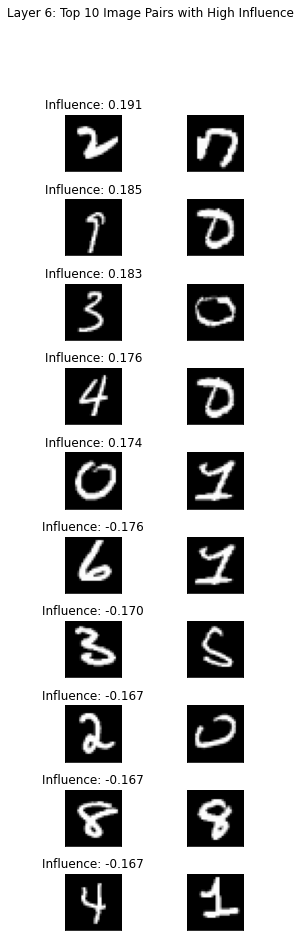

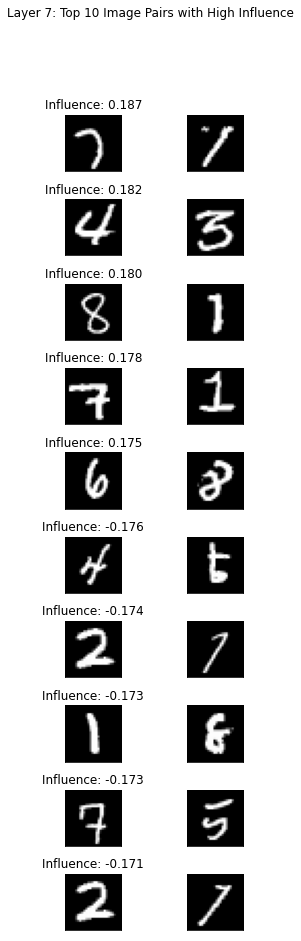

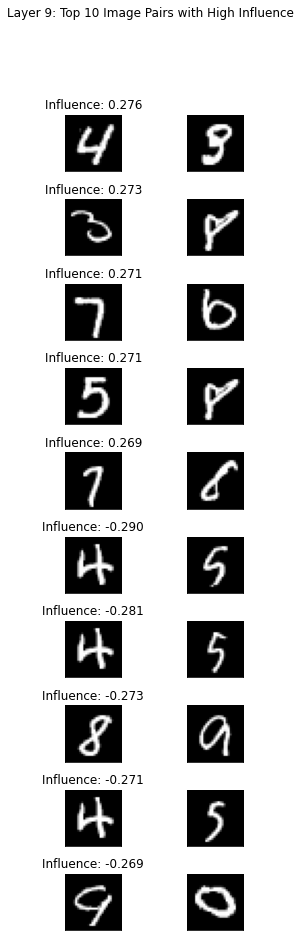

In [240]:
def plot_top_k_pairs(layer, top_k):
    # Call the get_top_k_pairs method
    idx1, idx2, influence_values  = get_top_k_pairs(layer, top_k)

    # Initialize the figure and axes
    fig, axes = plt.subplots(nrows=top_k, ncols=2, figsize=(4, top_k * 1.5))
    plt.subplots_adjust(hspace=0.5)

    for i in range(0, 2 * top_k):
        row = i //2
        # Get the images from the train dataset using the indices
        img1 = train.data[idx1[i]]
        img2 = train.data[idx2[i]]

        # Plot the images side by side
        axes[row, 0].imshow(img1, cmap='gray')
        axes[row, 1].imshow(img2, cmap='gray')

        # Remove axis labels
        axes[row, 0].set_xticks([])
        axes[row, 0].set_yticks([])
        axes[row, 1].set_xticks([])
        axes[row, 1].set_yticks([])

        # Display the influence value above the pair of images
        influence_value = influence_values[i]
        axes[row, 0].set_title(f"Influence: {influence_value:.3f}", fontsize=12)

    # Set the title
    fig.suptitle(f"Layer {layer}: Top {top_k} Image Pairs with High Influence")
    plt.show()

# Call the plot_top_k_pairs function for each layer
for layer in layer_to_topks_indicies.keys():
    plot_top_k_pairs(layer, 10)  # Change 10 to the desired top_k value

Layer 0


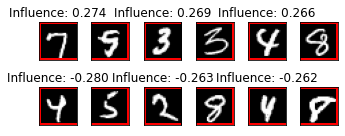

Layer 1


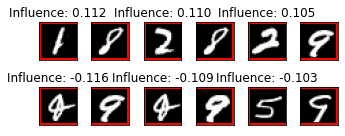

Layer 4


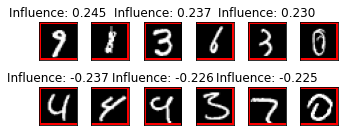

Layer 5


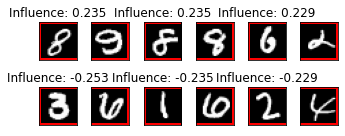

Layer 6


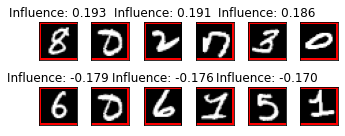

Layer 7


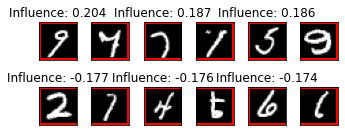

Layer 9


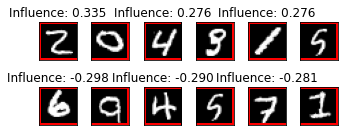

In [322]:
import matplotlib.patches as patches

def plot_top_k_pairs(layer, top_k, per_row=5, line_width=10):
    # Call the get_top_k_pairs method
    idx1, idx2, influence_values = get_top_k_pairs(layer, top_k)

    # Initialize the figure and axes
    num_rows = (top_k * 2) // (per_row)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2 * per_row, figsize=(1.5 * top_k, num_rows))
    #plt.subplots_adjust(wspace=0.5)

    for i in range(0, 4 * top_k, 2):
        row = i // (per_row* 2)
        col = (i % (per_row * 2))
        ind = i // 2

        # Get the images from the train dataset using the indices
        img1 = train.data[idx1[ind]]
        img2 = train.data[idx2[ind]]

        # Plot the images side by side
        axes[row, col].imshow(img1, cmap='gray')
        axes[row, col+1].imshow(img2, cmap='gray')

        # Remove axis labels
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        axes[row, col+1].set_xticks([])
        axes[row, col+1].set_yticks([])

        # Display the influence value above the pair of images
        influence_value = influence_values[ind]
        axes[row, col].set_title(f"Influence: {influence_value:.3f}", fontsize=12)
        
        # Add a rectangle around each pair of images
        # Add a rectangle around each pair of images
        pair_rect1 = patches.Rectangle((0, 0), 1.5, 1, linewidth=line_width, edgecolor='r', facecolor='none', transform=axes[row, col].transAxes)
        pair_rect2 = patches.Rectangle((-.5, 0), 1.5, 1, linewidth=line_width, edgecolor='r', facecolor='none', transform=axes[row, col+1].transAxes)
        axes[row, col].add_patch(pair_rect1)
        axes[row, col+1].add_patch(pair_rect2)

    plt.tight_layout()
    plt.show()
    #plt.close(plt.tight_layout())


# Call the function for each layer in layer_to_topks_indicies.keys()
for layer in layer_to_topks_indicies.keys():
    print(f"Layer {layer}")
    plot_top_k_pairs(layer, 3, per_row=3, line_width=4)

Layer 0
Layer 1
Layer 4
Layer 5
Layer 6
Layer 7
Layer 9


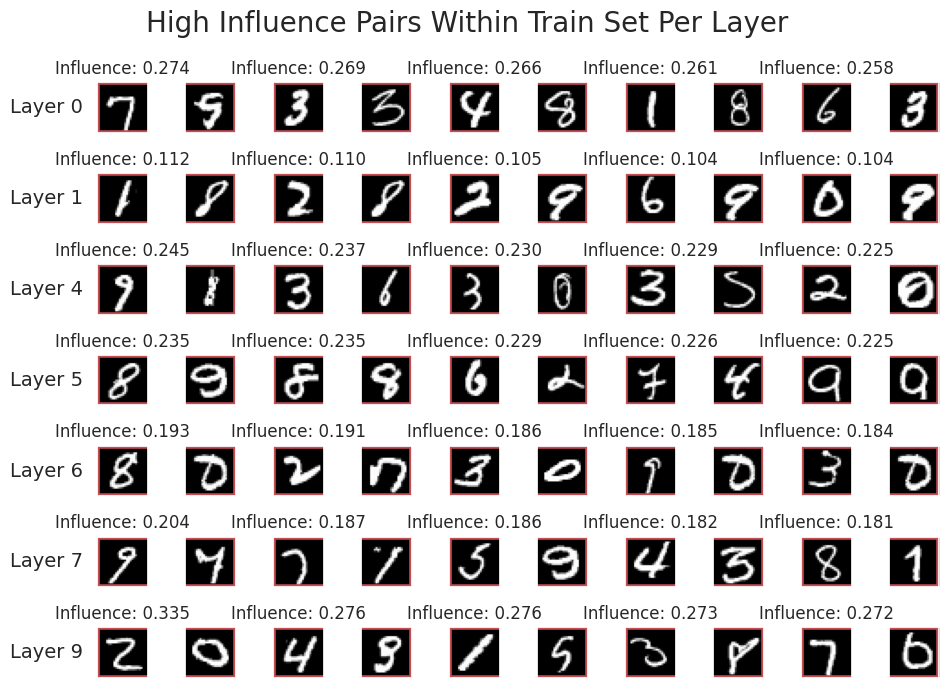

In [73]:
import matplotlib.patches as patches

def plot_top_k_pairs(j, layer, top_k, layer_to_topks, layer_to_topks_indicies, axes, per_row=5, line_width=10):
    # Call the get_top_k_pairs method
    idx1, idx2, influence_values = get_top_k_pairs(layer, top_k)

    for i in range(0, 2 * top_k, 2):
        row = i // (per_row * 2)
        col = (i % (per_row * 2))
        ind = i // 2

        # Get the images from the train dataset using the indices
        img1 = train.data[idx1[ind]]
        img2 = train.data[idx2[ind]]

        # Plot the images side by side
        axes[j + row, col].imshow(img1, cmap='gray')
        axes[j + row, col+1].imshow(img2, cmap='gray')

        # Remove axis labels
        axes[j + row, col].set_xticks([])
        axes[j + row, col].set_yticks([])
        axes[j + row, col+1].set_xticks([])
        axes[j + row, col+1].set_yticks([])

        # Display the influence value above the pair of images
        influence_value = influence_values[ind]
        axes[j + row, col].set_title(f"Influence: {influence_value:.3f}", fontsize=12)
        
        # Add a rectangle around each pair of images
        pair_rect1 = patches.Rectangle((0, 0), 1.5, 1, linewidth=line_width, edgecolor='r', facecolor='none', transform=axes[j + row, col].transAxes)
        pair_rect2 = patches.Rectangle((-.5, 0), 1.5, 1, linewidth=line_width, edgecolor='r', facecolor='none', transform=axes[j + row, col+1].transAxes)
        axes[j + row, col].add_patch(pair_rect1)
        axes[j + row, col+1].add_patch(pair_rect2)

def plot_all_layers(layer_to_sums_indicies, top_k, test_layer_to_topks, test_layer_to_topks_indicies, per_row=5, line_width=4):
    num_layers = len(layer_to_sums_indicies.keys())
    num_rows = (top_k) // (per_row)
    fig, axes = plt.subplots(nrows=num_rows * num_layers, ncols=2 * per_row, figsize=(2 * top_k, num_rows * num_layers))
    #print(axes[0, 8])

    for i, layer in enumerate(layer_to_sums_indicies.keys()):
        print(f"Layer {layer}")
        plot_top_k_pairs(i, layer, top_k, test_layer_to_topks, test_layer_to_topks_indicies, axes, per_row=per_row, line_width=line_width)

    # Set title for the whole plot
    fig.suptitle("High Influence Pairs Within Train Set Per Layer", fontsize=20)

    # Add layer titles on the left side
    for layer_idx, layer in enumerate(layer_to_sums_indicies.keys()):
        axes[layer_idx * num_rows, 0].text(-1, 0.5, f"Layer {layer}", fontsize=14, ha='center', va='center', rotation='horizontal', transform=axes[layer_idx * num_rows, 0].transAxes)
    
    plt.tight_layout()
    plt.show()

plot_all_layers(layer_to_sums_indicies, 5, layer_to_topks, layer_to_topks_indicies, per_row=5, line_width=4)

In [ ]:
import matplotlib.patches as patches

def plot_top_k_pairs(layer, top_k, per_row=5):
    # Call the get_top_k_pairs method
    idx1, idx2, influence_values = get_top_k_pairs(layer, top_k)

    # Initialize the figure and axes
    num_rows = (top_k * 2) // (per_row)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2 * per_row, figsize=(2 * top_k, 2 * num_rows))
    #plt.subplots_adjust(wspace=0.5)

    for i in range(0, 4 * top_k, 2):
        row = i // (per_row* 2)
        col = (i % (per_row * 2))
        ind = i // 2

        # Get the images from the train dataset using the indices
        img1 = train.data[idx1[ind]]
        img2 = train.data[idx2[ind]]

        # Plot the images side by side
        axes[row, col].imshow(img1, cmap='gray')
        axes[row, col+1].imshow(img2, cmap='gray')

        # Remove axis labels
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        axes[row, col+1].set_xticks([])
        axes[row, col+1].set_yticks([])

        # Display the influence value above the pair of images
        influence_value = influence_values[ind]
        axes[row, col].set_title(f"Influence: {influence_value:.3f}", fontsize=12)
        
        # Add a rectangle around each pair of images
        # Add a rectangle around each pair of images
        pair_rect1 = patches.Rectangle((0, 0), 1.5, 1, linewidth=10, edgecolor='r', facecolor='none', transform=axes[row, col].transAxes)
        pair_rect2 = patches.Rectangle((-.5, 0), 1.5, 1, linewidth=10, edgecolor='r', facecolor='none', transform=axes[row, col+1].transAxes)
        axes[row, col].add_patch(pair_rect1)
        axes[row, col+1].add_patch(pair_rect2)

    plt.tight_layout()
    plt.show()
    #plt.close(plt.tight_layout())


# Call the function for each layer in layer_to_topks_indicies.keys()
for layer in layer_to_topks_indicies.keys():
    print(f"Layer {layer}")
    plot_top_k_pairs(layer, 10)

# Let's Look at Similarities Between Memorized Points

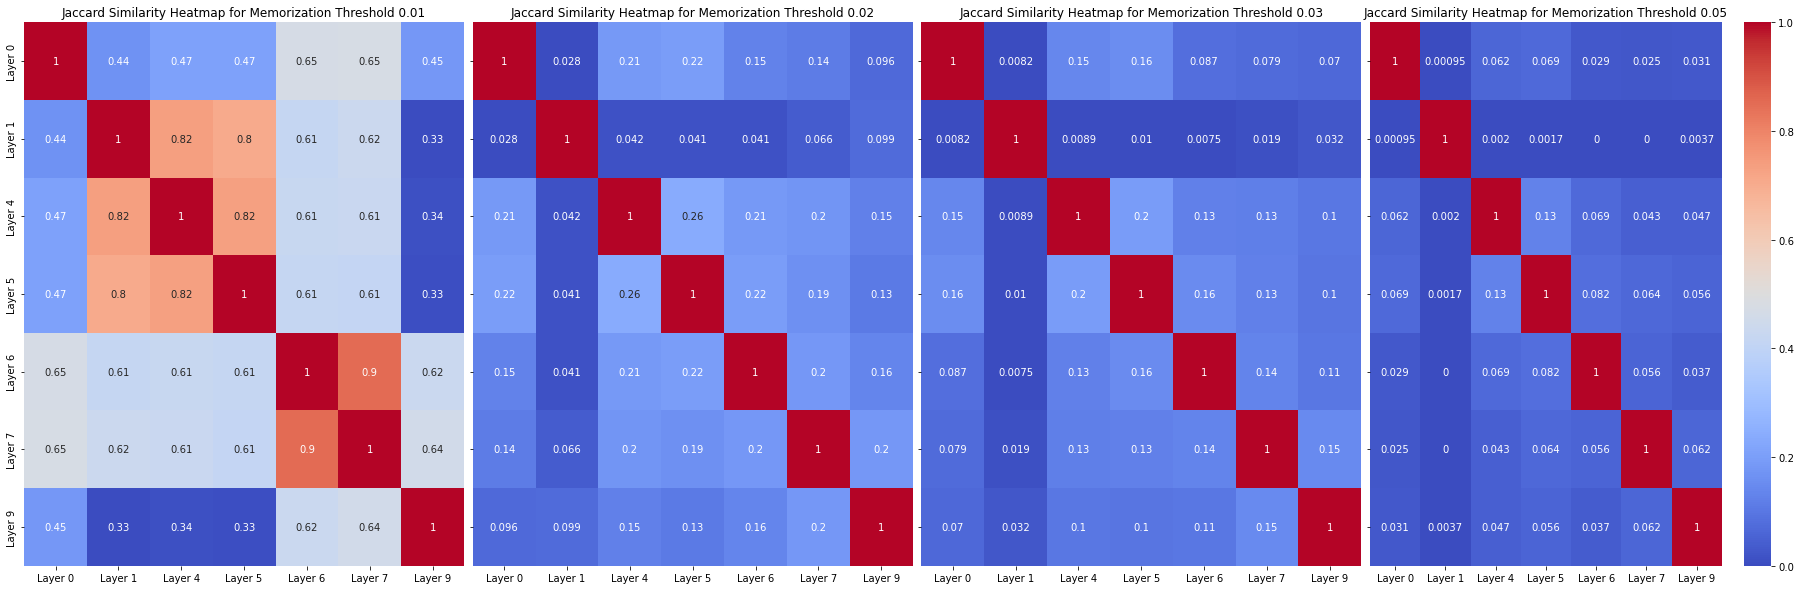

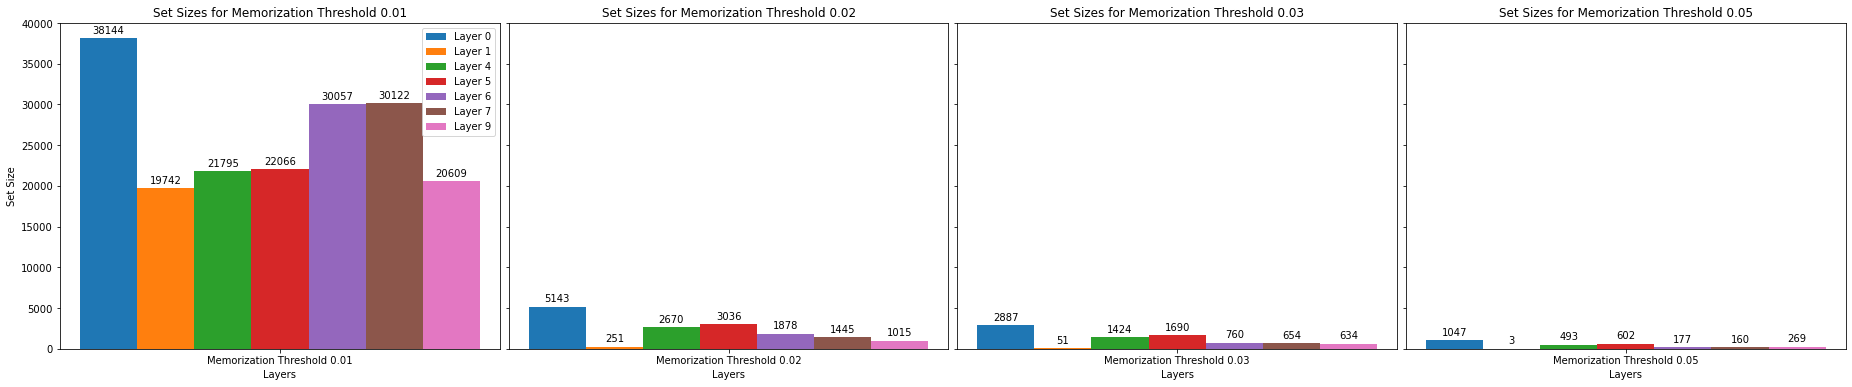

In [124]:
a = visualize_multi_gts([1e-2, 2e-2, 3e-2, 5e-2])

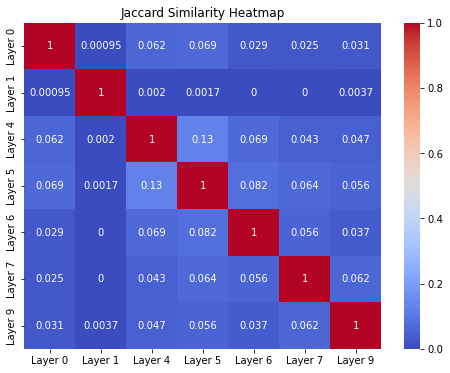

In [56]:
visualize_gt(.05)

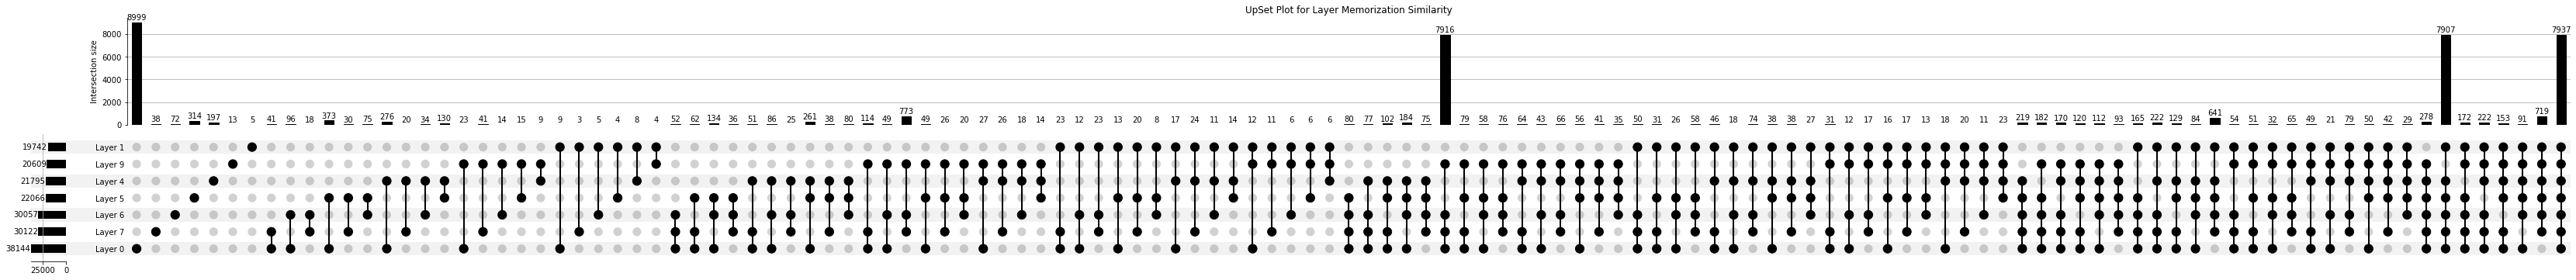

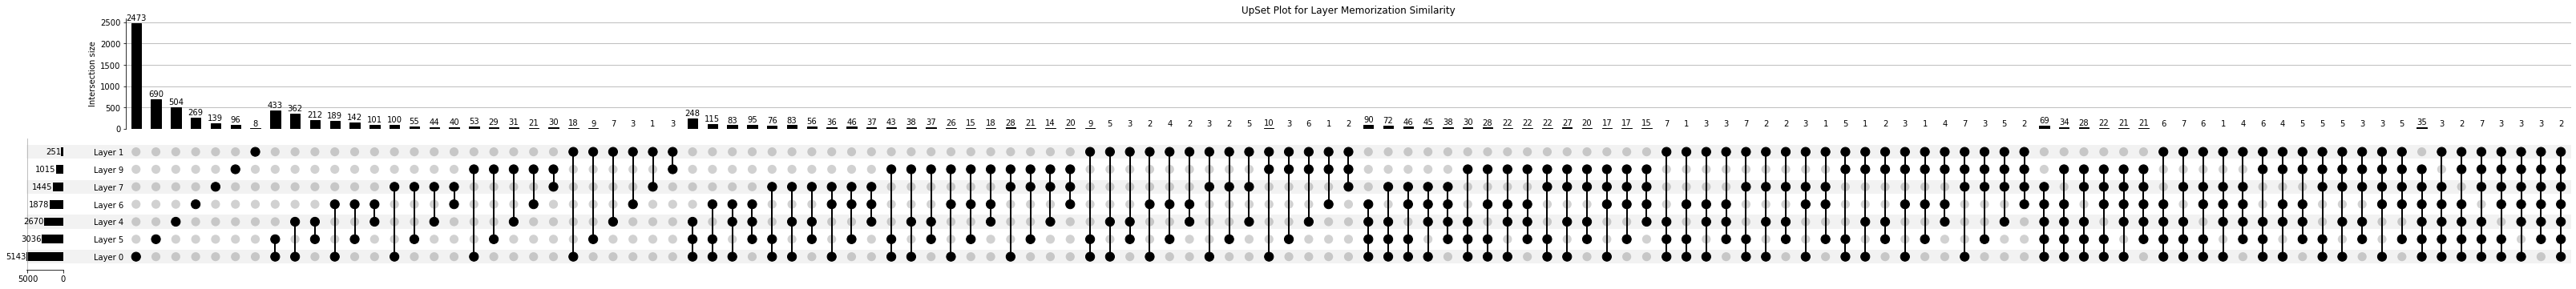

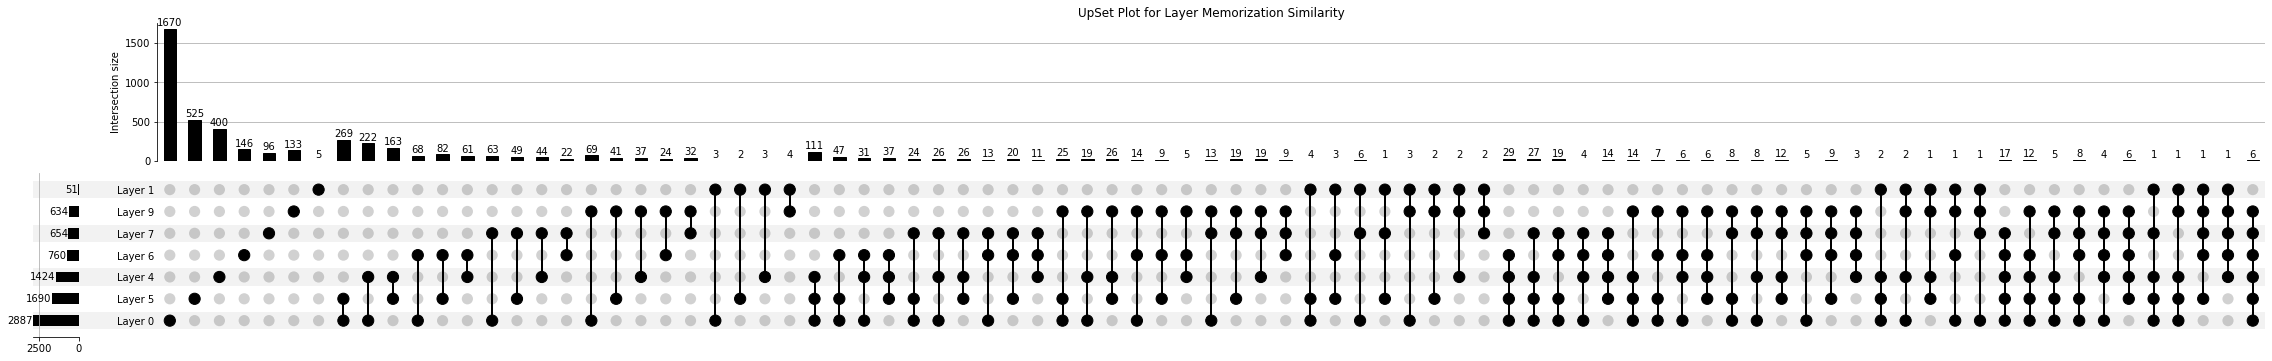

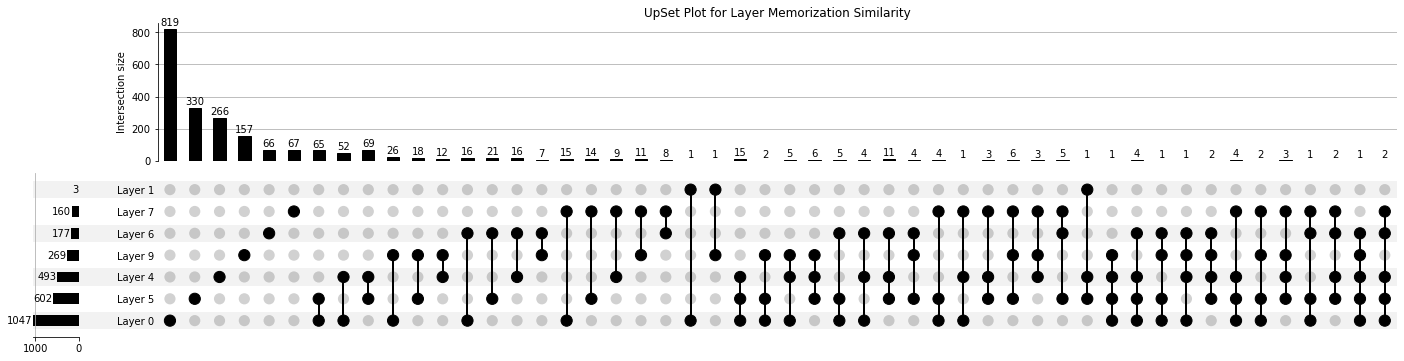

In [58]:
for i in [1e-2, 2e-2, 3e-2, 5e-2]:
    visualize_gt_upset(i)